In [3]:
import pickle
import torch
import os
import sys


data_dir = os.path.join('..', "outputs", "embeddings")
# with open(os.path.join(data_dir, "loaders_datasets.pkl"), 'rb') as f:
#     data = pickle.load(f)
data = torch.load(os.path.join(data_dir, "loaders_datasets.pt"))



In [4]:
for split in data.keys():
    for modal in ['audio', 'text', 'video']:
        modal_tensors = data[split][modal].tensors
        data[split][modal] = {
            'features': modal_tensors[0], 
            'labels': modal_tensors[1]   
        }

    if 'text' in data[split]:
        text_features = data[split]['text']['features']
        text_len_tensor = torch.sum((text_features != 0).long(), dim=1) 
        data[split]['text']['text_len_tensor'] = text_len_tensor


for split in data.keys():
    print(f"{split} audio features shape: {data[split]['audio']['features'].shape}")
    print(f"{split} text features shape: {data[split]['text']['features'].shape}")
    print(f"{split} video features shape: {data[split]['video']['features'].shape}")
    print(f"{split} text length tensor shape: {data[split]['text']['text_len_tensor'].shape}")


train audio features shape: torch.Size([9988, 768])
train text features shape: torch.Size([9988, 768])
train video features shape: torch.Size([9988, 16, 768])
train text length tensor shape: torch.Size([9988])
val audio features shape: torch.Size([1108, 768])
val text features shape: torch.Size([1108, 768])
val video features shape: torch.Size([1108, 16, 768])
val text length tensor shape: torch.Size([1108])
test audio features shape: torch.Size([2610, 768])
test text features shape: torch.Size([2610, 768])
test video features shape: torch.Size([2610, 16, 768])
test text length tensor shape: torch.Size([2610])


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, RGCNConv
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# -------- Préparer les données --------
def prepare_graph_data(data, split):
    # Moyennage sur la dimension temporelle pour la modalité vidéo
    video_features = torch.mean(data[split]['video']['features'], dim=1)  # Moyenne sur la dimension temporelle
    
    # Concaténer les features
    features = torch.cat([
        data[split]['audio']['features'],
        data[split]['text']['features'],
        video_features
    ], dim=0)
    
    # Concaténer les labels
    labels = torch.cat([
        data[split]['audio']['labels'],
        data[split]['text']['labels'],
        data[split]['video']['labels']
    ], dim=0)
    
    # Initialiser les listes pour edge_index et edge_type
    edge_index = []
    edge_type = []

    # -------- Relations temporelles intra-modales --------
    def add_temporal_edges(offset, num_nodes, relation_type):
        for i in range(num_nodes):
            if i > 0:
                edge_index.append([offset + i, offset + i - 1])  # -1 (passé)
                edge_type.append(relation_type)
            edge_index.append([offset + i, offset + i])  # 0 (présent)
            edge_type.append(relation_type + 1)
            if i < num_nodes - 1:
                edge_index.append([offset + i, offset + i + 1])  # +1 (futur)
                edge_type.append(relation_type + 2)

    # Ajouter les relations intra-modales
    num_audio = data[split]['audio']['features'].size(0)
    num_text = data[split]['text']['features'].size(0)
    num_video = video_features.size(0)  # Taille après réduction temporelle

    add_temporal_edges(0, num_audio, 0)  # Audio : relation types 0, 1, 2
    add_temporal_edges(num_audio, num_text, 3)  # Text : relation types 3, 4, 5
    add_temporal_edges(num_audio + num_text, num_video, 6)  # Video : relation types 6, 7, 8

    # -------- Relations cross-modales --------
    for i in range(min(num_audio, num_text, num_video)):
        edge_index.append([i, num_audio + num_text + i])  # Audio -> Video
        edge_type.append(9)
        edge_index.append([num_audio + i, num_audio + num_text + i])  # Text -> Video
        edge_type.append(10)
        edge_index.append([i, num_audio + i])  # Audio -> Text
        edge_type.append(11)

    # Convertir en tenseurs
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)

    print("Unique edge types:", torch.unique(edge_type))  # Debugging
    return Data(x=features, y=labels, edge_index=edge_index, edge_type=edge_type)

# -------- Définir les Modèles --------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.0):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)

# -------- Entraîner et Tester --------
def train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion, epochs=50):
    for epoch in range(epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        if isinstance(model, RGCN):
            out = model(train_data.x, train_data.edge_index, train_data.edge_type)
        
        else:
            out = model(train_data.x, train_data.edge_index)

        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            if isinstance(model, RGCN):
                val_out = model(val_data.x, val_data.edge_index, val_data.edge_type)
            else:
                val_out = model(val_data.x, val_data.edge_index)
            val_loss = criterion(val_out, val_data.y)
        print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Test
    model.eval()
    with torch.no_grad():
        if isinstance(model, RGCN):
            test_out = model(test_data.x, test_data.edge_index, test_data.edge_type)
        else:
            test_out = model(test_data.x, test_data.edge_index)
        test_pred = test_out.argmax(dim=1)
        test_acc = accuracy_score(test_data.y.cpu(), test_pred.cpu())
        test_f1 = f1_score(test_data.y.cpu(), test_pred.cpu(), average='macro')

    return test_acc, test_f1

# -------- Pipeline Principal --------
def main_pipeline(data):
    # Préparer les données
    train_data = prepare_graph_data(data, 'train')
    val_data = prepare_graph_data(data, 'val')
    test_data = prepare_graph_data(data, 'test')

    # Configurations de modèles
    architectures = [
        ("GCN (2 layers)", GCN(train_data.x.size(1), 64, len(torch.unique(train_data.y)))),
        ("GAT (4 heads)", GAT(train_data.x.size(1), 64, len(torch.unique(train_data.y)), heads=4)),
        ("RGCN", RGCN(train_data.x.size(1), 64, len(torch.unique(train_data.y)), num_relations=12)),
    ]

    # Entraîner et évaluer chaque modèle
    results = []
    for name, model in architectures:
        print(f"Training {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()
        acc, f1 = train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion)
        results.append((name, acc * 100, f1 * 100))

    # Afficher les résultats
    print("\nBenchmark Results:")
    print("Model\t\t\tTest Accuracy\tTest F1-Score")
    for name, acc, f1 in results:
        print(f"{name:20}\t{acc:.2f}\t\t{f1:.2f}")



In [8]:
main_pipeline(data)

Unique edge types: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Unique edge types: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Unique edge types: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Training GCN (2 layers)...
Epoch 1, Train Loss: 2.0698, Val Loss: 2.9119
Epoch 2, Train Loss: 2.6436, Val Loss: 1.9403
Epoch 3, Train Loss: 1.7549, Val Loss: 1.8179
Epoch 4, Train Loss: 1.7050, Val Loss: 1.8625
Epoch 5, Train Loss: 1.7826, Val Loss: 1.7592
Epoch 6, Train Loss: 1.6871, Val Loss: 1.6702
Epoch 7, Train Loss: 1.5956, Val Loss: 1.6452
Epoch 8, Train Loss: 1.5627, Val Loss: 1.6696
Epoch 9, Train Loss: 1.5786, Val Loss: 1.6953
Epoch 10, Train Loss: 1.5991, Val Loss: 1.6911
Epoch 11, Train Loss: 1.5936, Val Loss: 1.6602
Epoch 12, Train Loss: 1.5651, Val Loss: 1.6256
Epoch 13, Train Loss: 1.5345, Val Loss: 1.6090
Epoch 14, Train Loss: 1.5205, Val Loss: 1.6110
Epoch 15, Train Loss: 1.5221, Val Loss: 1.6187
Epoch 16, Train Loss: 1.5259, Val Loss: 1.6259
Ep

In [10]:
class CNN_Graph_Model(torch.nn.Module):
    def __init__(self, in_channels, cnn_channels, hidden_channels, out_channels, num_relations=None, graph_type="GCN", dropout=0.5):
        super(CNN_Graph_Model, self).__init__()
        # Couche CNN
        self.cnn = torch.nn.Conv1d(in_channels=in_channels, out_channels=cnn_channels, kernel_size=3, padding=1)
        
        # Type de couche graphique
        if graph_type == "GCN":
            self.graph_conv1 = GCNConv(cnn_channels, hidden_channels)
            self.graph_conv2 = GCNConv(hidden_channels, out_channels)
        elif graph_type == "GAT":
            self.graph_conv1 = GATConv(cnn_channels, hidden_channels, heads=4)
            self.graph_conv2 = GATConv(hidden_channels * 4, out_channels, heads=1)
        elif graph_type == "RGCN":
            assert num_relations is not None, "RGCN nécessite le nombre de relations"
            self.graph_conv1 = RGCNConv(cnn_channels, hidden_channels, num_relations)
            self.graph_conv2 = RGCNConv(hidden_channels, out_channels, num_relations)
        
        # MLP final
        self.fc1 = torch.nn.Linear(out_channels, 128)
        self.fc2 = torch.nn.Linear(128, out_channels)

        # Dropout
        self.dropout = dropout

    def forward(self, x, edge_index, edge_type=None):
        # Passer les données par la couche CNN
        x = x.unsqueeze(1)  # Ajouter une dimension de canal pour Conv1d
        x = self.cnn(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)  # Réduire les dimensions

        # Passer par la couche graphique
        if isinstance(self.graph_conv1, RGCNConv):  # RGCN
            x = self.graph_conv1(x, edge_index, edge_type)
        else:  # GCN ou GAT
            x = self.graph_conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        if isinstance(self.graph_conv2, RGCNConv):  # RGCN
            x = self.graph_conv2(x, edge_index, edge_type)
        else:  # GCN ou GAT
            x = self.graph_conv2(x, edge_index)

        # Passer par le MLP
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# -------- Entraîner et Évaluer le Modèle --------
def train_and_evaluate_with_cnn(model, train_data, val_data, test_data, optimizer, criterion, epochs=50):
    for epoch in range(epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        if isinstance(model.graph_conv1, RGCNConv):
            out = model(train_data.x, train_data.edge_index, train_data.edge_type)
        else:
            out = model(train_data.x, train_data.edge_index)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            if isinstance(model.graph_conv1, RGCNConv):
                val_out = model(val_data.x, val_data.edge_index, val_data.edge_type)
            else:
                val_out = model(val_data.x, val_data.edge_index)
            val_loss = criterion(val_out, val_data.y)
        print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Test
    model.eval()
    with torch.no_grad():
        if isinstance(model.graph_conv1, RGCNConv):
            test_out = model(test_data.x, test_data.edge_index, test_data.edge_type)
        else:
            test_out = model(test_data.x, test_data.edge_index)
        test_pred = test_out.argmax(dim=1)
        test_acc = accuracy_score(test_data.y.cpu(), test_pred.cpu())
        test_f1 = f1_score(test_data.y.cpu(), test_pred.cpu(), average='macro')

    return test_acc, test_f1

# -------- Pipeline Principal avec CNN + Graph --------
def main_pipeline_with_cnn(data):
    # Préparer les données
    train_data = prepare_graph_data(data, 'train')
    val_data = prepare_graph_data(data, 'val')
    test_data = prepare_graph_data(data, 'test')

    # Configurations de modèles
    architectures = [
        ("GCN + CNN + MLP", CNN_Graph_Model(train_data.x.size(1), 32, 64, len(torch.unique(train_data.y)), graph_type="GCN")),
        ("GAT + CNN + MLP", CNN_Graph_Model(train_data.x.size(1), 32, 64, len(torch.unique(train_data.y)), graph_type="GAT")),
        ("RGCN + CNN + MLP", CNN_Graph_Model(train_data.x.size(1), 32, 64, len(torch.unique(train_data.y)), num_relations=12, graph_type="RGCN")),
    ]

    # Entraîner et évaluer chaque modèle
    results = []
    for name, model in architectures:
        print(f"Training {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()
        acc, f1 = train_and_evaluate_with_cnn(model, train_data, val_data, test_data, optimizer, criterion)
        results.append((name, acc * 100, f1 * 100))

    # Afficher les résultats
    print("\nBenchmark Results:")
    print("Model\t\t\tTest Accuracy\tTest F1-Score")
    for name, acc, f1 in results:
        print(f"{name:20}\t{acc:.2f}\t\t{f1:.2f}")
main_pipeline(data)

Unique edge types: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Unique edge types: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Unique edge types: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Training GCN (2 layers)...
Epoch 1, Train Loss: 1.9243, Val Loss: 2.8714
Epoch 2, Train Loss: 2.5615, Val Loss: 1.9500
Epoch 3, Train Loss: 1.7542, Val Loss: 1.7222
Epoch 4, Train Loss: 1.6235, Val Loss: 1.7466
Epoch 5, Train Loss: 1.6940, Val Loss: 1.7209
Epoch 6, Train Loss: 1.6786, Val Loss: 1.6745
Epoch 7, Train Loss: 1.6260, Val Loss: 1.6390
Epoch 8, Train Loss: 1.5764, Val Loss: 1.6336
Epoch 9, Train Loss: 1.5536, Val Loss: 1.6564
Epoch 10, Train Loss: 1.5592, Val Loss: 1.6833
Epoch 11, Train Loss: 1.5718, Val Loss: 1.6930
Epoch 12, Train Loss: 1.5730, Val Loss: 1.6799
Epoch 13, Train Loss: 1.5588, Val Loss: 1.6550
Epoch 14, Train Loss: 1.5390, Val Loss: 1.6342
Epoch 15, Train Loss: 1.5263, Val Loss: 1.6231
Epoch 16, Train Loss: 1.5239, Val Loss: 1.6191
Ep

Normalization graph

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, RGCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# -------- Normalisation des Features --------
def normalize_features(features):
    scaler = StandardScaler()
    normalized = scaler.fit_transform(features.cpu().numpy())
    return torch.tensor(normalized, dtype=torch.float)

# -------- Préparer les données --------
def prepare_graph_data(data, split):
    # Moyennage sur la dimension temporelle pour la modalité vidéo
    video_features = torch.mean(data[split]['video']['features'], dim=1)  # Moyenne sur la dimension temporelle

    # Concaténer les features
    features = torch.cat([
        normalize_features(data[split]['audio']['features']),
        normalize_features(data[split]['text']['features']),
        normalize_features(video_features)
    ], dim=0)

    # Concaténer les labels
    labels = torch.cat([
        data[split]['audio']['labels'],
        data[split]['text']['labels'],
        data[split]['video']['labels']
    ], dim=0)

    # Initialiser les listes pour edge_index et edge_type
    edge_index = []
    edge_type = []

    # -------- Relations temporelles intra-modales --------
    def add_temporal_edges(offset, num_nodes, relation_type):
        for i in range(num_nodes):
            if i > 0:
                edge_index.append([offset + i, offset + i - 1])  # -1 (passé)
                edge_type.append(relation_type)
            edge_index.append([offset + i, offset + i])  # 0 (présent)
            edge_type.append(relation_type + 1)
            if i < num_nodes - 1:
                edge_index.append([offset + i, offset + i + 1])  # +1 (futur)
                edge_type.append(relation_type + 2)

    # Ajouter les relations intra-modales
    num_audio = data[split]['audio']['features'].size(0)
    num_text = data[split]['text']['features'].size(0)
    num_video = video_features.size(0)  # Taille après réduction temporelle

    add_temporal_edges(0, num_audio, 0)  # Audio : relation types 0, 1, 2
    add_temporal_edges(num_audio, num_text, 3)  # Text : relation types 3, 4, 5
    add_temporal_edges(num_audio + num_text, num_video, 6)  # Video : relation types 6, 7, 8

    # -------- Relations cross-modales --------
    for i in range(min(num_audio, num_text, num_video)):
        edge_index.append([i, num_audio + num_text + i])  # Audio -> Video
        edge_type.append(9)
        edge_index.append([num_audio + i, num_audio + num_text + i])  # Text -> Video
        edge_type.append(10)
        edge_index.append([i, num_audio + i])  # Audio -> Text
        edge_type.append(11)

    # Convertir en tenseurs
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)

    return Data(x=features, y=labels, edge_index=edge_index, edge_type=edge_type)

# -------- Modèle GCN --------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.0):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# -------- Entraîner et Tester --------
def train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion, epochs=50):
    for epoch in range(epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        out = model(train_data.x, train_data.edge_index)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data.x, val_data.edge_index)
            val_loss = criterion(val_out, val_data.y)
        print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Test
    model.eval()
    with torch.no_grad():
        test_out = model(test_data.x, test_data.edge_index)
        test_pred = test_out.argmax(dim=1)
        test_acc = accuracy_score(test_data.y.cpu(), test_pred.cpu())
        test_f1 = f1_score(test_data.y.cpu(), test_pred.cpu(), average='macro')

    return test_acc, test_f1

# -------- Pipeline Principal --------
def main_pipeline(data):
    # Préparer les données
    train_data = prepare_graph_data(data, 'train')
    val_data = prepare_graph_data(data, 'val')
    test_data = prepare_graph_data(data, 'test')

    # Configurer le modèle
    model = GCN(train_data.x.size(1), 64, len(torch.unique(train_data.y)), dropout=0.5)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Entraîner et évaluer
    acc, f1 = train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion)

    print(f"\nTest Accuracy: {acc * 100:.2f}%, Test F1-Score: {f1 * 100:.2f}%")

# -------- Exemple d'utilisation --------
# data = charger_les_donnees()  # Implémentez cette fonction pour charger vos données.
main_pipeline(data)


Epoch 1, Train Loss: 1.8920, Val Loss: 1.8419
Epoch 2, Train Loss: 1.8026, Val Loss: 1.8997
Epoch 3, Train Loss: 1.8555, Val Loss: 1.6505
Epoch 4, Train Loss: 1.6581, Val Loss: 1.6332
Epoch 5, Train Loss: 1.6640, Val Loss: 1.6459
Epoch 6, Train Loss: 1.6624, Val Loss: 1.5598
Epoch 7, Train Loss: 1.5539, Val Loss: 1.5819
Epoch 8, Train Loss: 1.5402, Val Loss: 1.6112
Epoch 9, Train Loss: 1.5483, Val Loss: 1.5850
Epoch 10, Train Loss: 1.5023, Val Loss: 1.5640
Epoch 11, Train Loss: 1.4678, Val Loss: 1.5555
Epoch 12, Train Loss: 1.4631, Val Loss: 1.5326
Epoch 13, Train Loss: 1.4498, Val Loss: 1.5167
Epoch 14, Train Loss: 1.4371, Val Loss: 1.5158
Epoch 15, Train Loss: 1.4296, Val Loss: 1.5106
Epoch 16, Train Loss: 1.4181, Val Loss: 1.5030
Epoch 17, Train Loss: 1.3998, Val Loss: 1.5069
Epoch 18, Train Loss: 1.4013, Val Loss: 1.5112
Epoch 19, Train Loss: 1.3991, Val Loss: 1.5012
Epoch 20, Train Loss: 1.3872, Val Loss: 1.4902
Epoch 21, Train Loss: 1.3792, Val Loss: 1.4872
Epoch 22, Train Loss: 

Batch Norm + Dropout

## **Improvement**

**1. Normalisation des Données**

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, RGCNConv, BatchNorm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# -------- Normalisation des Features --------
def normalize_features(features):
    scaler = StandardScaler()
    normalized = scaler.fit_transform(features.cpu().numpy())
    return torch.tensor(normalized, dtype=torch.float)

# -------- Préparer les données --------
def prepare_graph_data(data, split):
    # Moyennage sur la dimension temporelle pour la modalité vidéo
    video_features = torch.mean(data[split]['video']['features'], dim=1)  # Moyenne sur la dimension temporelle

    # Concaténer les features
    features = torch.cat([
        normalize_features(data[split]['audio']['features']),
        normalize_features(data[split]['text']['features']),
        normalize_features(video_features)
    ], dim=0)

    # Concaténer les labels
    labels = torch.cat([
        data[split]['audio']['labels'],
        data[split]['text']['labels'],
        data[split]['video']['labels']
    ], dim=0)

    # Initialiser les listes pour edge_index et edge_type
    edge_index = []
    edge_type = []

    # -------- Relations temporelles intra-modales --------
    def add_temporal_edges(offset, num_nodes, relation_type):
        for i in range(num_nodes):
            if i > 0:
                edge_index.append([offset + i, offset + i - 1])  # -1 (passé)
                edge_type.append(relation_type)
            edge_index.append([offset + i, offset + i])  # 0 (présent)
            edge_type.append(relation_type + 1)
            if i < num_nodes - 1:
                edge_index.append([offset + i, offset + i + 1])  # +1 (futur)
                edge_type.append(relation_type + 2)

    # Ajouter les relations intra-modales
    num_audio = data[split]['audio']['features'].size(0)
    num_text = data[split]['text']['features'].size(0)
    num_video = video_features.size(0)  # Taille après réduction temporelle

    add_temporal_edges(0, num_audio, 0)  # Audio : relation types 0, 1, 2
    add_temporal_edges(num_audio, num_text, 3)  # Text : relation types 3, 4, 5
    add_temporal_edges(num_audio + num_text, num_video, 6)  # Video : relation types 6, 7, 8

    # -------- Relations cross-modales --------
    for i in range(min(num_audio, num_text, num_video)):
        edge_index.append([i, num_audio + num_text + i])  # Audio -> Video
        edge_type.append(9)
        edge_index.append([num_audio + i, num_audio + num_text + i])  # Text -> Video
        edge_type.append(10)
        edge_index.append([i, num_audio + i])  # Audio -> Text
        edge_type.append(11)

    # Convertir en tenseurs
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)

    return Data(x=features, y=labels, edge_index=edge_index, edge_type=edge_type)

# -------- Modèle GCN --------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.0):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.batch_norm1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.batch_norm2 = BatchNorm(out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        return F.log_softmax(x, dim=1)

# -------- Modèle GAT --------
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.0):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.batch_norm1 = BatchNorm(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.batch_norm2 = BatchNorm(out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        return F.log_softmax(x, dim=1)

# -------- Modèle RGCN --------
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations, dropout=0.0):
        super(RGCN, self).__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.batch_norm1 = BatchNorm(hidden_channels)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)
        self.batch_norm2 = BatchNorm(out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        x = self.batch_norm2(x)
        return F.log_softmax(x, dim=1)

# -------- Entraîner et Tester --------
def train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion, epochs=50):
    for epoch in range(epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        if isinstance(model, RGCN):
            out = model(train_data.x, train_data.edge_index, train_data.edge_type)
        else:
            out = model(train_data.x, train_data.edge_index)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            if isinstance(model, RGCN):
                val_out = model(val_data.x, val_data.edge_index, val_data.edge_type)
            else:
                val_out = model(val_data.x, val_data.edge_index)
            val_loss = criterion(val_out, val_data.y)
        print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Test
    model.eval()
    with torch.no_grad():
        if isinstance(model, RGCN):
            test_out = model(test_data.x, test_data.edge_index, test_data.edge_type)
        else:
            test_out = model(test_data.x, test_data.edge_index)
        test_pred = test_out.argmax(dim=1)
        test_acc = accuracy_score(test_data.y.cpu(), test_pred.cpu())
        test_f1 = f1_score(test_data.y.cpu(), test_pred.cpu(), average='macro')

    return test_acc, test_f1

# -------- Pipeline Principal --------
def main_pipeline(data):
    # Préparer les données
    train_data = prepare_graph_data(data, 'train')
    val_data = prepare_graph_data(data, 'val')
    test_data = prepare_graph_data(data, 'test')

    # Configurations de modèles
    architectures = [
        ("GCN", GCN(train_data.x.size(1), 64, len(torch.unique(train_data.y)), dropout=0.5)),
        ("GAT", GAT(train_data.x.size(1), 64, len(torch.unique(train_data.y)), heads=4, dropout=0.5)),
        ("RGCN", RGCN(train_data.x.size(1), 64, len(torch.unique(train_data.y)), num_relations=12, dropout=0.5))
    ]

    # Entraîner et évaluer chaque modèle
    results = []
    for name, model in architectures:
        print(f"Training {name}...")
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
        criterion = torch.nn.CrossEntropyLoss()
        acc, f1 = train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion)
        results.append((name, acc * 100, f1 * 100))

    # Afficher les résultats
    print("\nBenchmark Results:")
    print("Model\t\t\tTest Accuracy\tTest F1-Score")
    for name, acc, f1 in results:
        print(f"{name:20}\t{acc:.2f}\t\t{f1:.2f}")

# -------- Exemple d'utilisation --------
# data = charger_les_donnees()  # Implémentez cette fonction pour charger vos données.
main_pipeline(data)


Training GCN...
Epoch 1, Train Loss: 2.3531, Val Loss: 1.9481
Epoch 2, Train Loss: 2.1039, Val Loss: 1.9520
Epoch 3, Train Loss: 1.9941, Val Loss: 1.8708
Epoch 4, Train Loss: 1.9136, Val Loss: 1.8321
Epoch 5, Train Loss: 1.8674, Val Loss: 1.8555
Epoch 6, Train Loss: 1.8404, Val Loss: 1.8692
Epoch 7, Train Loss: 1.8256, Val Loss: 1.8534
Epoch 8, Train Loss: 1.8062, Val Loss: 1.8290
Epoch 9, Train Loss: 1.7902, Val Loss: 1.8071
Epoch 10, Train Loss: 1.7799, Val Loss: 1.7898
Epoch 11, Train Loss: 1.7692, Val Loss: 1.7783
Epoch 12, Train Loss: 1.7614, Val Loss: 1.7709
Epoch 13, Train Loss: 1.7485, Val Loss: 1.7660
Epoch 14, Train Loss: 1.7397, Val Loss: 1.7619
Epoch 15, Train Loss: 1.7314, Val Loss: 1.7588
Epoch 16, Train Loss: 1.7262, Val Loss: 1.7549
Epoch 17, Train Loss: 1.7159, Val Loss: 1.7506
Epoch 18, Train Loss: 1.7048, Val Loss: 1.7464
Epoch 19, Train Loss: 1.7008, Val Loss: 1.7430
Epoch 20, Train Loss: 1.6907, Val Loss: 1.7410
Epoch 21, Train Loss: 1.6823, Val Loss: 1.7385
Epoch 

**Improove RGCN**

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, RGCNConv, BatchNorm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# -------- Normalisation des Features --------
def normalize_features(features):
    scaler = StandardScaler()
    normalized = scaler.fit_transform(features.cpu().numpy())
    return torch.tensor(normalized, dtype=torch.float)

# -------- Préparer les données --------
def prepare_graph_data(data, split):
    # Moyennage sur la dimension temporelle pour la modalité vidéo
    video_features = torch.mean(data[split]['video']['features'], dim=1)  # Moyenne sur la dimension temporelle

    # Concaténer les features
    features = torch.cat([
        normalize_features(data[split]['audio']['features']),
        normalize_features(data[split]['text']['features']),
        normalize_features(video_features)
    ], dim=0)

    # Concaténer les labels
    labels = torch.cat([
        data[split]['audio']['labels'],
        data[split]['text']['labels'],
        data[split]['video']['labels']
    ], dim=0)

    # Initialiser les listes pour edge_index et edge_type
    edge_index = []
    edge_type = []

    # -------- Relations temporelles intra-modales --------
    def add_temporal_edges(offset, num_nodes, relation_type):
        for i in range(num_nodes):
            if i > 0:
                edge_index.append([offset + i, offset + i - 1])  # -1 (passé)
                edge_type.append(relation_type)
            edge_index.append([offset + i, offset + i])  # 0 (présent)
            edge_type.append(relation_type + 1)
            if i < num_nodes - 1:
                edge_index.append([offset + i, offset + i + 1])  # +1 (futur)
                edge_type.append(relation_type + 2)

    # Ajouter les relations intra-modales
    num_audio = data[split]['audio']['features'].size(0)
    num_text = data[split]['text']['features'].size(0)
    num_video = video_features.size(0)  # Taille après réduction temporelle

    add_temporal_edges(0, num_audio, 0)  # Audio : relation types 0, 1, 2
    add_temporal_edges(num_audio, num_text, 3)  # Text : relation types 3, 4, 5
    add_temporal_edges(num_audio + num_text, num_video, 6)  # Video : relation types 6, 7, 8

    # -------- Relations cross-modales --------
    for i in range(min(num_audio, num_text, num_video)):
        edge_index.append([i, num_audio + num_text + i])  # Audio -> Video
        edge_type.append(9)
        edge_index.append([num_audio + i, num_audio + num_text + i])  # Text -> Video
        edge_type.append(10)
        edge_index.append([i, num_audio + i])  # Audio -> Text
        edge_type.append(11)

    # Convertir en tenseurs
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)

    return Data(x=features, y=labels, edge_index=edge_index, edge_type=edge_type)

# -------- Modèle CNN + RGCN + MLP --------
class CNN_RGCN_MLP(torch.nn.Module):
    def __init__(self, in_channels, cnn_channels, hidden_channels, out_channels, num_relations, dropout=0.0):
        super(CNN_RGCN_MLP, self).__init__()
        # Couche CNN
        self.cnn = torch.nn.Conv1d(in_channels=1, out_channels=cnn_channels, kernel_size=3, padding=1)
        self.cnn_batch_norm = BatchNorm(cnn_channels)

        # RGCN
        self.rgcn1 = RGCNConv(cnn_channels, hidden_channels, num_relations)
        self.rgcn_bn1 = BatchNorm(hidden_channels)
        self.rgcn2 = RGCNConv(hidden_channels, hidden_channels, num_relations)
        self.rgcn_bn2 = BatchNorm(hidden_channels)

        # MLP Final
        self.fc1 = torch.nn.Linear(hidden_channels, 128)
        self.fc2 = torch.nn.Linear(128, out_channels)

        self.dropout = dropout

    def forward(self, x, edge_index, edge_type):
        # CNN sur les features
        x = x.unsqueeze(1)  # Ajouter une dimension pour Conv1d
        x = self.cnn(x)
        x = self.cnn_batch_norm(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)  # Réduction des dimensions

        # RGCN
        x = self.rgcn1(x, edge_index, edge_type)
        x = self.rgcn_bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.rgcn2(x, edge_index, edge_type)
        x = self.rgcn_bn2(x)
        x = F.relu(x)

        # MLP Final
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# -------- Entraîner et Tester --------
def train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion, epochs=50):
    for epoch in range(epochs):
        # Entraînement
        model.train()
        optimizer.zero_grad()
        out = model(train_data.x, train_data.edge_index, train_data.edge_type)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data.x, val_data.edge_index, val_data.edge_type)
            val_loss = criterion(val_out, val_data.y)
        print(f"Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Test
    model.eval()
    with torch.no_grad():
        test_out = model(test_data.x, test_data.edge_index, test_data.edge_type)
        test_pred = test_out.argmax(dim=1)
        test_acc = accuracy_score(test_data.y.cpu(), test_pred.cpu())
        test_f1 = f1_score(test_data.y.cpu(), test_pred.cpu(), average='macro')

    return test_acc, test_f1

# -------- Pipeline Principal --------
def main_pipeline(data):
    # Préparer les données
    train_data = prepare_graph_data(data, 'train')
    val_data = prepare_graph_data(data, 'val')
    test_data = prepare_graph_data(data, 'test')

    # Configurer le modèle
    model = CNN_RGCN_MLP(
        in_channels=train_data.x.size(1),
        cnn_channels=32,
        hidden_channels=64,
        out_channels=len(torch.unique(train_data.y)),
        num_relations=12,
        dropout=0.5
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # Entraîner et évaluer
    acc, f1 = train_and_evaluate(model, train_data, val_data, test_data, optimizer, criterion)

    print(f"\nTest Accuracy: {acc * 100:.2f}%, Test F1-Score: {f1 * 100:.2f}%")

# -------- Exemple d'utilisation --------
# data = charger_les_donnees()  # Implémentez cette fonction pour charger vos données.
main_pipeline(data)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (29964x24576 and 32x64)

**LOADING FUNCTION**

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from processing.preprocessing import prepare_graph_data, prepare_dataloaders
from models.MultiHeadAttention import MultiheadAttention
from models.CrossModalNet import CrossmodalNet
from models.Transformers import TransformerEncoder
from models.CombineModel import CombinedModel
from models.GraphModel import GraphModel
from trainning.trainning import train_model as train
from trainning.trainning import evaluate_model as evaluate
import torch
import torch.nn as nn

from data.loaddata import load_data
import torch


data = load_data(data_type='loaders_datasets.pt')

c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
data

{'train': {'audio': {'features': tensor([[ 0.0939,  0.0762,  0.0689,  ...,  0.2469,  0.3439, -0.3689],
           [-0.0282,  0.0721,  0.4385,  ...,  0.4353,  0.0995, -0.0296],
           [-0.0721,  0.1159,  0.1769,  ...,  0.4833,  0.0715,  0.0421],
           ...,
           [ 0.0865,  0.2816, -0.2080,  ...,  0.1752,  0.2943, -0.0734],
           [ 0.1912,  0.0553,  0.0986,  ...,  0.3378,  0.1588, -0.1218],
           [ 0.0359,  0.1585, -0.2475,  ...,  0.2054,  0.3535, -0.2127]]),
   'labels': tensor([0, 0, 0,  ..., 6, 0, 1])},
  'text': {'features': tensor([[-0.1967,  0.1299,  0.1679,  ..., -0.2378,  0.2947,  0.1266],
           [ 0.0635,  0.3604, -0.5336,  ..., -0.5177,  0.5179,  0.2851],
           [-0.0813,  0.3107,  0.0133,  ..., -0.1899,  0.4385,  0.1935],
           ...,
           [ 0.4822,  0.2613, -0.1825,  ..., -0.3868,  0.6702,  0.4198],
           [-0.3271, -0.0116, -0.0164,  ..., -0.1454,  0.4163,  0.1177],
           [-0.1336, -0.3128, -0.4481,  ..., -0.0193,  0.1588,  0

In [19]:
print(data['train']['audio']['labels'].shape, data['train']['text']['labels'].shape, data['train']['video']['labels'].shape)
# count values in each label
print(torch.unique(data['train']['audio']['labels'], return_counts=True)) 

# train
unique_labels, counts = torch.unique(data['train']['audio']['labels'], return_counts=True)
sorted_indices = torch.argsort(counts, descending=True)
representative_labels = unique_labels[sorted_indices[:4]]
print(representative_labels)
audio_indices = torch.isin(data['train']['audio']['labels'], representative_labels)
text_indices = torch.isin(data['train']['text']['labels'], representative_labels)
video_indices = torch.isin(data['train']['video']['labels'], representative_labels)

# dev
audio_indices_dev = torch.isin(data['val']['audio']['labels'], representative_labels)
text_indices_dev = torch.isin(data['val']['text']['labels'], representative_labels)
video_indices_dev = torch.isin(data['val']['video']['labels'], representative_labels)

# test
audio_indices_test = torch.isin(data['test']['audio']['labels'], representative_labels)
text_indices_test = torch.isin(data['test']['text']['labels'], representative_labels)
video_indices_test = torch.isin(data['test']['video']['labels'], representative_labels)

subdata = {
    'train': {
        'audio': {
            'features': data['train']['audio']['features'][audio_indices],
            'labels': data['train']['audio']['labels'][audio_indices]
        },
        'text': {
            'features': data['train']['text']['features'][text_indices],
            'labels': data['train']['text']['labels'][text_indices]
        },
        'video': {
            'features': data['train']['video']['features'][video_indices],
            'labels': data['train']['video']['labels'][video_indices]
        }
    },
    'val': {
        'audio': {
            'features': data['val']['audio']['features'][audio_indices_dev],
            'labels': data['val']['audio']['labels'][audio_indices_dev]
        },
        'text': {
            'features': data['val']['text']['features'][text_indices_dev],
            'labels': data['val']['text']['labels'][text_indices_dev]
        },
        'video': {
            'features': data['val']['video']['features'][video_indices_dev],
            'labels': data['val']['video']['labels'][video_indices_dev]
        }
    },
    'test': {
        'audio': {
            'features': data['test']['audio']['features'][audio_indices_test],
            'labels': data['test']['audio']['labels'][audio_indices_test]
        },
        'text': {
            'features': data['test']['text']['features'][text_indices_test],
            'labels': data['test']['text']['labels'][text_indices_test]
        },
        'video': {
            'features': data['test']['video']['features'][video_indices_test],
            'labels': data['test']['video']['labels'][video_indices_test]
        }
    }
}
# Filtrer les données pour les classes les plus représentatives
subdata['train']['audio']['labels'] = data['train']['audio']['labels'][audio_indices]
subdata['train']['audio']['features'] = data['train']['audio']['features'][audio_indices]
subdata['train']['text']['features'] = data['train']['text']['features'][text_indices]
subdata['train']['text']['labels'] = data['train']['text']['labels'][text_indices]
subdata['train']['video']['features'] = data['train']['video']['features'][video_indices]
subdata['train']['video']['labels'] = data['train']['video']['labels'][video_indices]

# checking the shape of the data and values count in each label
print(subdata['train']['audio']['labels'].shape, subdata['train']['text']['labels'].shape, subdata['train']['video']['labels'].shape)
print(torch.unique(subdata['train']['audio']['labels'], return_counts=True))
print(torch.unique(subdata['test']['audio']['labels'], return_counts=True))
print(torch.unique(subdata['val']['audio']['labels'], return_counts=True))



torch.Size([9988]) torch.Size([9988]) torch.Size([9988])
(tensor([0, 1, 2, 3, 4, 5, 6]), tensor([4709, 1743, 1109,  271,  683,  268, 1205]))
tensor([0, 1, 6, 2])
torch.Size([8766]) torch.Size([8766]) torch.Size([8766])
(tensor([0, 1, 2, 6]), tensor([4709, 1743, 1109, 1205]))
(tensor([0, 1, 2, 6]), tensor([1256,  402,  345,  281]))
(tensor([0, 1, 2, 6]), tensor([469, 163, 153, 150]))


In [20]:
label_mapping = {label.item(): idx for idx, label in enumerate(representative_labels)}
print(f"Label Mapping: {label_mapping}")

def reindex_labels(labels, mapping):
    return torch.tensor([mapping[label.item()] for label in labels], dtype=torch.long)

subdata['train']['audio']['labels'] = reindex_labels(subdata['train']['audio']['labels'], label_mapping)
subdata['train']['text']['labels'] = reindex_labels(subdata['train']['text']['labels'], label_mapping)
subdata['train']['video']['labels'] = reindex_labels(subdata['train']['video']['labels'], label_mapping)

subdata['val']['audio']['labels'] = reindex_labels(subdata['val']['audio']['labels'], label_mapping)
subdata['val']['text']['labels'] = reindex_labels(subdata['val']['text']['labels'], label_mapping)
subdata['val']['video']['labels'] = reindex_labels(subdata['val']['video']['labels'], label_mapping)

subdata['test']['audio']['labels'] = reindex_labels(subdata['test']['audio']['labels'], label_mapping)
subdata['test']['text']['labels'] = reindex_labels(subdata['test']['text']['labels'], label_mapping)
subdata['test']['video']['labels'] = reindex_labels(subdata['test']['video']['labels'], label_mapping)


print(torch.unique(subdata['train']['audio']['labels'], return_counts=True))
print(torch.unique(subdata['val']['audio']['labels'], return_counts=True))
print(torch.unique(subdata['test']['audio']['labels'], return_counts=True))


Label Mapping: {0: 0, 1: 1, 6: 2, 2: 3}
(tensor([0, 1, 2, 3]), tensor([4709, 1743, 1205, 1109]))
(tensor([0, 1, 2, 3]), tensor([469, 163, 150, 153]))
(tensor([0, 1, 2, 3]), tensor([1256,  402,  281,  345]))


In [27]:
args = {
    'modalities': ['audio', 'text', 'video'],
    'edge_type': ['temp', 'multi'],
    'wp': 3,
    'wf': 3,
    'crossmodal_nheads': 4,
    'num_crossmodal':2,
    'self_att_nheads': 4,
    'num_self_att':2,
    
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [28]:
subtrain_features, subtrain_labels, subtrain_lengths = prepare_graph_data(subdata['train'], args)
subdev_features, subdev_labels, subdev_lengths = prepare_graph_data(subdata['val'], args)
subtest_features, subtest_labels, subtest_lengths = prepare_graph_data(subdata['test'], args)

subtrain_loader = prepare_dataloaders(subtrain_features, subtrain_labels, subtrain_lengths, batch_size=32)
subval_loader = prepare_dataloaders(subdev_features, subdev_labels, subdev_lengths, batch_size=32)
subtest_loader = prepare_dataloaders(subtest_features, subtest_labels, subtest_lengths, batch_size=32)


[DEBUG] Prepared features shape: torch.Size([26298, 768])
[DEBUG] Prepared labels shape: torch.Size([26298])
[DEBUG] Prepared lengths: [8766, 8766, 8766]
[DEBUG] Prepared features shape: torch.Size([2805, 768])
[DEBUG] Prepared labels shape: torch.Size([2805])
[DEBUG] Prepared lengths: [935, 935, 935]
[DEBUG] Prepared features shape: torch.Size([6852, 768])
[DEBUG] Prepared labels shape: torch.Size([6852])
[DEBUG] Prepared lengths: [2284, 2284, 2284]


In [29]:
crossmodal_model = CrossmodalNet(inchannels=256, args=args).to(args['device'])  
graphModel = GraphModel(768, 128, 64, args['device'], args).to(args['device'])
optimizer = torch.optim.Adam(graphModel.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train(graphModel, subtrain_loader, subval_loader, optimizer, criterion, args, epochs=50)


GraphModel --> Edge type: ['temp', 'multi']
GraphModel --> Window past: 3
GraphModel --> Window future: 3


Epoch 1 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 1 train loss 1.607980345359974, val loss 1.1807164705612443


Testing: 100%|██████████| 88/88 [00:01<00:00, 61.65it/s]


[DEBUG] Test Accuracy: 54.69%, Test F1 Score: 34.12%
[DEBUG] Class 0 - Precision: 55.99%, Recall: 93.03%, F1-Score: 69.91%
[DEBUG] Class 1 - Precision: 51.60%, Recall: 19.84%, F1-Score: 28.66%
[DEBUG] Class 2 - Precision: 43.68%, Recall: 25.33%, F1-Score: 32.07%
[DEBUG] Class 3 - Precision: 77.78%, Recall: 3.05%, F1-Score: 5.87%
{'0': {'precision': 0.5598802395209581, 'recall': 0.9303482587064676, 'f1-score': 0.6990654205607477, 'support': 1407.0}, '1': {'precision': 0.5159574468085106, 'recall': 0.1983640081799591, 'f1-score': 0.2865583456425406, 'support': 489.0}, '2': {'precision': 0.4367816091954023, 'recall': 0.25333333333333335, 'f1-score': 0.3206751054852321, 'support': 450.0}, '3': {'precision': 0.7777777777777778, 'recall': 0.030501089324618737, 'f1-score': 0.05870020964360587, 'support': 459.0}, 'accuracy': 0.5468805704099822, 'macro avg': {'precision': 0.5725992683256622, 'recall': 0.3531366723860947, 'f1-score': 0.34124977033303155, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 2 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 2 train loss 1.0712202921546, val loss 1.1252954724160107


Testing: 100%|██████████| 88/88 [00:01<00:00, 61.50it/s]


[DEBUG] Test Accuracy: 55.58%, Test F1 Score: 34.44%
[DEBUG] Class 0 - Precision: 55.41%, Recall: 96.80%, F1-Score: 70.48%
[DEBUG] Class 1 - Precision: 56.34%, Recall: 16.36%, F1-Score: 25.36%
[DEBUG] Class 2 - Precision: 65.43%, Recall: 11.78%, F1-Score: 19.96%
[DEBUG] Class 3 - Precision: 51.61%, Recall: 13.94%, F1-Score: 21.96%
{'0': {'precision': 0.5541090317331163, 'recall': 0.9680170575692963, 'f1-score': 0.7047865459249677, 'support': 1407.0}, '1': {'precision': 0.5633802816901409, 'recall': 0.16359918200409, 'f1-score': 0.25356576862123614, 'support': 489.0}, '2': {'precision': 0.654320987654321, 'recall': 0.11777777777777777, 'f1-score': 0.19962335216572505, 'support': 450.0}, '3': {'precision': 0.5161290322580645, 'recall': 0.1394335511982571, 'f1-score': 0.2195540308747856, 'support': 459.0}, 'accuracy': 0.5557932263814617, 'macro avg': {'precision': 0.5719848333339106, 'recall': 0.34720689213735534, 'f1-score': 0.34438242439667865, 'support': 2805.0}, 'weighted avg': {'prec

Epoch 3 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 3 train loss 1.0555579769640364, val loss 1.1156589117917148


Testing: 100%|██████████| 88/88 [00:01<00:00, 55.96it/s]


[DEBUG] Test Accuracy: 55.86%, Test F1 Score: 37.10%
[DEBUG] Class 0 - Precision: 57.24%, Recall: 93.82%, F1-Score: 71.10%
[DEBUG] Class 1 - Precision: 41.70%, Recall: 22.09%, F1-Score: 28.88%
[DEBUG] Class 2 - Precision: 63.89%, Recall: 15.33%, F1-Score: 24.73%
[DEBUG] Class 3 - Precision: 53.03%, Recall: 15.25%, F1-Score: 23.69%
{'0': {'precision': 0.572419774501301, 'recall': 0.9381663113006397, 'f1-score': 0.7110153514678158, 'support': 1407.0}, '1': {'precision': 0.416988416988417, 'recall': 0.22085889570552147, 'f1-score': 0.2887700534759358, 'support': 489.0}, '2': {'precision': 0.6388888888888888, 'recall': 0.15333333333333332, 'f1-score': 0.24731182795698925, 'support': 450.0}, '3': {'precision': 0.5303030303030303, 'recall': 0.15250544662309368, 'f1-score': 0.23688663282571912, 'support': 459.0}, 'accuracy': 0.5586452762923351, 'macro avg': {'precision': 0.5396500276704093, 'recall': 0.36621599674064703, 'f1-score': 0.370995966431615, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 4 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 4 train loss 1.0483380907063358, val loss 1.1106155162507838


Testing: 100%|██████████| 88/88 [00:01<00:00, 64.63it/s]


[DEBUG] Test Accuracy: 55.94%, Test F1 Score: 36.73%
[DEBUG] Class 0 - Precision: 55.82%, Recall: 95.10%, F1-Score: 70.35%
[DEBUG] Class 1 - Precision: 64.29%, Recall: 14.72%, F1-Score: 23.96%
[DEBUG] Class 2 - Precision: 53.25%, Recall: 20.00%, F1-Score: 29.08%
[DEBUG] Class 3 - Precision: 54.33%, Recall: 15.03%, F1-Score: 23.55%
{'0': {'precision': 0.55819774718398, 'recall': 0.9509594882729211, 'f1-score': 0.7034700315457413, 'support': 1407.0}, '1': {'precision': 0.6428571428571429, 'recall': 0.147239263803681, 'f1-score': 0.23960066555740434, 'support': 489.0}, '2': {'precision': 0.5325443786982249, 'recall': 0.2, 'f1-score': 0.29079159935379645, 'support': 450.0}, '3': {'precision': 0.5433070866141733, 'recall': 0.1503267973856209, 'f1-score': 0.2354948805460751, 'support': 459.0}, 'accuracy': 0.5593582887700534, 'macro avg': {'precision': 0.5692265888383803, 'recall': 0.3621313873655557, 'f1-score': 0.3673392942507543, 'support': 2805.0}, 'weighted avg': {'precision': 0.56640438

Epoch 5 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 5 train loss 1.0408196082370416, val loss 1.1157577654177493


Testing: 100%|██████████| 88/88 [00:01<00:00, 66.94it/s]


[DEBUG] Test Accuracy: 55.54%, Test F1 Score: 34.49%
[DEBUG] Class 0 - Precision: 55.82%, Recall: 96.45%, F1-Score: 70.71%
[DEBUG] Class 1 - Precision: 51.74%, Recall: 18.20%, F1-Score: 26.93%
[DEBUG] Class 2 - Precision: 63.10%, Recall: 11.78%, F1-Score: 19.85%
[DEBUG] Class 3 - Precision: 50.00%, Recall: 12.85%, F1-Score: 20.45%
{'0': {'precision': 0.55820649938297, 'recall': 0.9644633972992182, 'f1-score': 0.7071391349661282, 'support': 1407.0}, '1': {'precision': 0.5174418604651163, 'recall': 0.18200408997955012, 'f1-score': 0.2692889561270802, 'support': 489.0}, '2': {'precision': 0.6309523809523809, 'recall': 0.11777777777777777, 'f1-score': 0.19850187265917604, 'support': 450.0}, '3': {'precision': 0.5, 'recall': 0.12854030501089325, 'f1-score': 0.2045060658578856, 'support': 459.0}, 'accuracy': 0.5554367201426025, 'macro avg': {'precision': 0.5516501852001168, 'recall': 0.34819639251685985, 'f1-score': 0.34485900740256753, 'support': 2805.0}, 'weighted avg': {'precision': 0.553

Epoch 6 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 6 train loss 1.0335750650170366, val loss 1.1050527034835382


Testing: 100%|██████████| 88/88 [00:01<00:00, 59.43it/s]


[DEBUG] Test Accuracy: 56.29%, Test F1 Score: 36.04%
[DEBUG] Class 0 - Precision: 55.65%, Recall: 96.94%, F1-Score: 70.71%
[DEBUG] Class 1 - Precision: 62.60%, Recall: 16.77%, F1-Score: 26.45%
[DEBUG] Class 2 - Precision: 62.93%, Recall: 16.22%, F1-Score: 25.80%
[DEBUG] Class 3 - Precision: 56.07%, Recall: 13.07%, F1-Score: 21.20%
{'0': {'precision': 0.5565075479396164, 'recall': 0.9694385216773277, 'f1-score': 0.7071021254536028, 'support': 1407.0}, '1': {'precision': 0.6259541984732825, 'recall': 0.16768916155419222, 'f1-score': 0.2645161290322581, 'support': 489.0}, '2': {'precision': 0.6293103448275862, 'recall': 0.1622222222222222, 'f1-score': 0.2579505300353357, 'support': 450.0}, '3': {'precision': 0.5607476635514018, 'recall': 0.13071895424836602, 'f1-score': 0.21201413427561838, 'support': 459.0}, 'accuracy': 0.5629233511586452, 'macro avg': {'precision': 0.5931299386979718, 'recall': 0.357517214925527, 'f1-score': 0.36039572969920375, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 7 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 7 train loss 1.0282907852146168, val loss 1.1003034060651606


Testing: 100%|██████████| 88/88 [00:01<00:00, 66.01it/s]


[DEBUG] Test Accuracy: 56.29%, Test F1 Score: 35.79%
[DEBUG] Class 0 - Precision: 55.63%, Recall: 97.30%, F1-Score: 70.79%
[DEBUG] Class 1 - Precision: 66.36%, Recall: 14.52%, F1-Score: 23.83%
[DEBUG] Class 2 - Precision: 62.71%, Recall: 16.44%, F1-Score: 26.06%
[DEBUG] Class 3 - Precision: 54.62%, Recall: 14.16%, F1-Score: 22.49%
{'0': {'precision': 0.5562779357984559, 'recall': 0.9729921819474058, 'f1-score': 0.7078593588417788, 'support': 1407.0}, '1': {'precision': 0.6635514018691588, 'recall': 0.14519427402862986, 'f1-score': 0.23825503355704697, 'support': 489.0}, '2': {'precision': 0.6271186440677966, 'recall': 0.16444444444444445, 'f1-score': 0.2605633802816901, 'support': 450.0}, '3': {'precision': 0.5462184873949579, 'recall': 0.14161220043572983, 'f1-score': 0.22491349480968859, 'support': 459.0}, 'accuracy': 0.5629233511586452, 'macro avg': {'precision': 0.5982916172825923, 'recall': 0.3560607752140525, 'f1-score': 0.3578978168725512, 'support': 2805.0}, 'weighted avg': {'p

Epoch 8 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 8 train loss 1.0211019014210017, val loss 1.1049536283720622


Testing: 100%|██████████| 88/88 [00:01<00:00, 64.03it/s]


[DEBUG] Test Accuracy: 56.93%, Test F1 Score: 40.63%
[DEBUG] Class 0 - Precision: 58.08%, Recall: 92.25%, F1-Score: 71.28%
[DEBUG] Class 1 - Precision: 46.52%, Recall: 21.88%, F1-Score: 29.76%
[DEBUG] Class 2 - Precision: 54.95%, Recall: 22.22%, F1-Score: 31.65%
[DEBUG] Class 3 - Precision: 58.23%, Recall: 20.04%, F1-Score: 29.82%
{'0': {'precision': 0.5807606263982102, 'recall': 0.9225302061122956, 'f1-score': 0.7127951674903898, 'support': 1407.0}, '1': {'precision': 0.4652173913043478, 'recall': 0.21881390593047034, 'f1-score': 0.29763560500695413, 'support': 489.0}, '2': {'precision': 0.5494505494505495, 'recall': 0.2222222222222222, 'f1-score': 0.31645569620253167, 'support': 450.0}, '3': {'precision': 0.5822784810126582, 'recall': 0.20043572984749455, 'f1-score': 0.29821717990275526, 'support': 459.0}, 'accuracy': 0.5693404634581105, 'macro avg': {'precision': 0.5444267620414414, 'recall': 0.3910005160281207, 'f1-score': 0.4062759121506578, 'support': 2805.0}, 'weighted avg': {'p

Epoch 9 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 9 train loss 1.0152652869114331, val loss 1.1140624907883732


Testing: 100%|██████████| 88/88 [00:01<00:00, 61.83it/s]


[DEBUG] Test Accuracy: 56.65%, Test F1 Score: 37.48%
[DEBUG] Class 0 - Precision: 56.06%, Recall: 95.95%, F1-Score: 70.77%
[DEBUG] Class 1 - Precision: 54.26%, Recall: 20.86%, F1-Score: 30.13%
[DEBUG] Class 2 - Precision: 67.27%, Recall: 16.44%, F1-Score: 26.43%
[DEBUG] Class 3 - Precision: 63.64%, Recall: 13.73%, F1-Score: 22.58%
{'0': {'precision': 0.5606312292358804, 'recall': 0.9594882729211087, 'f1-score': 0.7077326343381389, 'support': 1407.0}, '1': {'precision': 0.5425531914893617, 'recall': 0.2085889570552147, 'f1-score': 0.30132939438700146, 'support': 489.0}, '2': {'precision': 0.6727272727272727, 'recall': 0.16444444444444445, 'f1-score': 0.2642857142857143, 'support': 450.0}, '3': {'precision': 0.6363636363636364, 'recall': 0.13725490196078433, 'f1-score': 0.22580645161290322, 'support': 459.0}, 'accuracy': 0.5664884135472371, 'macro avg': {'precision': 0.6030688324540378, 'recall': 0.367444144095388, 'f1-score': 0.37478854865593947, 'support': 2805.0}, 'weighted avg': {'pr

Epoch 10 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 10 train loss 1.0101269923712506, val loss 1.116445079445839


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.14it/s]


[DEBUG] Test Accuracy: 56.54%, Test F1 Score: 38.00%
[DEBUG] Class 0 - Precision: 56.63%, Recall: 95.02%, F1-Score: 70.97%
[DEBUG] Class 1 - Precision: 50.81%, Recall: 19.22%, F1-Score: 27.89%
[DEBUG] Class 2 - Precision: 67.52%, Recall: 17.56%, F1-Score: 27.87%
[DEBUG] Class 3 - Precision: 53.52%, Recall: 16.56%, F1-Score: 25.29%
{'0': {'precision': 0.566285472257518, 'recall': 0.9502487562189055, 'f1-score': 0.7096602972399151, 'support': 1407.0}, '1': {'precision': 0.5081081081081081, 'recall': 0.19222903885480572, 'f1-score': 0.2789317507418398, 'support': 489.0}, '2': {'precision': 0.6752136752136753, 'recall': 0.17555555555555555, 'f1-score': 0.2786596119929453, 'support': 450.0}, '3': {'precision': 0.5352112676056338, 'recall': 0.1655773420479303, 'f1-score': 0.2529118136439268, 'support': 459.0}, 'accuracy': 0.5654188948306595, 'macro avg': {'precision': 0.5712046307962337, 'recall': 0.37090267316929926, 'f1-score': 0.38004086840465673, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 11 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 11 train loss 1.0060066286374763, val loss 1.122918452051553


Testing: 100%|██████████| 88/88 [00:01<00:00, 55.34it/s]


[DEBUG] Test Accuracy: 56.01%, Test F1 Score: 37.36%
[DEBUG] Class 0 - Precision: 57.24%, Recall: 93.89%, F1-Score: 71.12%
[DEBUG] Class 1 - Precision: 53.80%, Recall: 17.38%, F1-Score: 26.28%
[DEBUG] Class 2 - Precision: 71.26%, Recall: 13.78%, F1-Score: 23.09%
[DEBUG] Class 3 - Precision: 40.87%, Recall: 22.44%, F1-Score: 28.97%
{'0': {'precision': 0.5723570190641247, 'recall': 0.9388770433546553, 'f1-score': 0.7111709286675639, 'support': 1407.0}, '1': {'precision': 0.5379746835443038, 'recall': 0.1738241308793456, 'f1-score': 0.26275115919629055, 'support': 489.0}, '2': {'precision': 0.7126436781609196, 'recall': 0.13777777777777778, 'f1-score': 0.2309124767225326, 'support': 450.0}, '3': {'precision': 0.4087301587301587, 'recall': 0.22440087145969498, 'f1-score': 0.28973277074542897, 'support': 459.0}, 'accuracy': 0.5600713012477718, 'macro avg': {'precision': 0.5579263848748767, 'recall': 0.36871995586786843, 'f1-score': 0.373641833832954, 'support': 2805.0}, 'weighted avg': {'pr

Epoch 12 Training:   0%|          | 0/822 [00:22<?, ?it/s]


[DEBUG] Epoch 12 train loss 1.000538905244094, val loss 1.1115747710520572


Testing: 100%|██████████| 88/88 [00:01<00:00, 62.43it/s]


[DEBUG] Test Accuracy: 56.36%, Test F1 Score: 37.24%
[DEBUG] Class 0 - Precision: 56.70%, Recall: 95.31%, F1-Score: 71.10%
[DEBUG] Class 1 - Precision: 71.28%, Recall: 13.70%, F1-Score: 22.98%
[DEBUG] Class 2 - Precision: 63.79%, Recall: 16.44%, F1-Score: 26.15%
[DEBUG] Class 3 - Precision: 43.04%, Recall: 21.57%, F1-Score: 28.74%
{'0': {'precision': 0.5670190274841438, 'recall': 0.9530916844349681, 'f1-score': 0.7110286320254506, 'support': 1407.0}, '1': {'precision': 0.7127659574468085, 'recall': 0.13701431492842536, 'f1-score': 0.22984562607204118, 'support': 489.0}, '2': {'precision': 0.6379310344827587, 'recall': 0.16444444444444445, 'f1-score': 0.26148409893992935, 'support': 450.0}, '3': {'precision': 0.43043478260869567, 'recall': 0.21568627450980393, 'f1-score': 0.28737300435413643, 'support': 459.0}, 'accuracy': 0.5636363636363636, 'macro avg': {'precision': 0.5870377005056017, 'recall': 0.3675591795794104, 'f1-score': 0.3724328403478894, 'support': 2805.0}, 'weighted avg': {

Epoch 13 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 13 train loss 0.9937618276208566, val loss 1.1172834932804108


Testing: 100%|██████████| 88/88 [00:01<00:00, 64.02it/s]


[DEBUG] Test Accuracy: 56.90%, Test F1 Score: 38.46%
[DEBUG] Class 0 - Precision: 57.06%, Recall: 95.38%, F1-Score: 71.40%
[DEBUG] Class 1 - Precision: 58.74%, Recall: 17.18%, F1-Score: 26.58%
[DEBUG] Class 2 - Precision: 60.54%, Recall: 19.78%, F1-Score: 29.82%
[DEBUG] Class 3 - Precision: 49.69%, Recall: 17.65%, F1-Score: 26.05%
{'0': {'precision': 0.5705782312925171, 'recall': 0.9538024164889837, 'f1-score': 0.7140196860867252, 'support': 1407.0}, '1': {'precision': 0.5874125874125874, 'recall': 0.17177914110429449, 'f1-score': 0.26582278481012656, 'support': 489.0}, '2': {'precision': 0.6054421768707483, 'recall': 0.19777777777777777, 'f1-score': 0.2981574539363484, 'support': 450.0}, '3': {'precision': 0.49693251533742333, 'recall': 0.17647058823529413, 'f1-score': 0.2604501607717042, 'support': 459.0}, 'accuracy': 0.5689839572192513, 'macro avg': {'precision': 0.5650913777283191, 'recall': 0.37495748090158754, 'f1-score': 0.3846125214012261, 'support': 2805.0}, 'weighted avg': {'

Epoch 14 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 14 train loss 0.9898739319358139, val loss 1.1101467209783467


Testing: 100%|██████████| 88/88 [00:01<00:00, 62.80it/s]


[DEBUG] Test Accuracy: 56.79%, Test F1 Score: 38.66%
[DEBUG] Class 0 - Precision: 57.03%, Recall: 94.81%, F1-Score: 71.22%
[DEBUG] Class 1 - Precision: 59.20%, Recall: 15.13%, F1-Score: 24.10%
[DEBUG] Class 2 - Precision: 64.29%, Recall: 20.00%, F1-Score: 30.51%
[DEBUG] Class 3 - Precision: 47.26%, Recall: 20.70%, F1-Score: 28.79%
{'0': {'precision': 0.5703292005130398, 'recall': 0.9481165600568585, 'f1-score': 0.7122263747997865, 'support': 1407.0}, '1': {'precision': 0.592, 'recall': 0.15132924335378323, 'f1-score': 0.24104234527687296, 'support': 489.0}, '2': {'precision': 0.6428571428571429, 'recall': 0.2, 'f1-score': 0.3050847457627119, 'support': 450.0}, '3': {'precision': 0.472636815920398, 'recall': 0.20697167755991286, 'f1-score': 0.2878787878787879, 'support': 459.0}, 'accuracy': 0.5679144385026738, 'macro avg': {'precision': 0.5694557898226451, 'recall': 0.37660437024263865, 'f1-score': 0.3865580634295398, 'support': 2805.0}, 'weighted avg': {'precision': 0.5697565767968, 'r

Epoch 15 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 15 train loss 0.9868526699479189, val loss 1.115903715518388


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.75it/s]


[DEBUG] Test Accuracy: 55.90%, Test F1 Score: 37.05%
[DEBUG] Class 0 - Precision: 56.58%, Recall: 94.17%, F1-Score: 70.69%
[DEBUG] Class 1 - Precision: 49.53%, Recall: 21.68%, F1-Score: 30.16%
[DEBUG] Class 2 - Precision: 67.71%, Recall: 14.44%, F1-Score: 23.81%
[DEBUG] Class 3 - Precision: 47.06%, Recall: 15.69%, F1-Score: 23.53%
{'0': {'precision': 0.5657557643040136, 'recall': 0.9417199715707179, 'f1-score': 0.7068551613763671, 'support': 1407.0}, '1': {'precision': 0.4953271028037383, 'recall': 0.2167689161554192, 'f1-score': 0.3015647226173542, 'support': 489.0}, '2': {'precision': 0.6770833333333334, 'recall': 0.14444444444444443, 'f1-score': 0.23809523809523808, 'support': 450.0}, '3': {'precision': 0.47058823529411764, 'recall': 0.1568627450980392, 'f1-score': 0.23529411764705882, 'support': 459.0}, 'accuracy': 0.5590017825311943, 'macro avg': {'precision': 0.5521886089338007, 'recall': 0.3649490193171552, 'f1-score': 0.3704523099340046, 'support': 2805.0}, 'weighted avg': {'pr

Epoch 16 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 16 train loss 0.978025425017025, val loss 1.1305288618261164


Testing: 100%|██████████| 88/88 [00:01<00:00, 62.78it/s]


[DEBUG] Test Accuracy: 55.90%, Test F1 Score: 39.63%
[DEBUG] Class 0 - Precision: 58.15%, Recall: 89.98%, F1-Score: 70.65%
[DEBUG] Class 1 - Precision: 54.97%, Recall: 16.97%, F1-Score: 25.94%
[DEBUG] Class 2 - Precision: 65.55%, Recall: 17.33%, F1-Score: 27.42%
[DEBUG] Class 3 - Precision: 39.39%, Recall: 30.72%, F1-Score: 34.52%
{'0': {'precision': 0.5815342214056041, 'recall': 0.8997867803837953, 'f1-score': 0.7064732142857143, 'support': 1407.0}, '1': {'precision': 0.5496688741721855, 'recall': 0.16973415132924335, 'f1-score': 0.259375, 'support': 489.0}, '2': {'precision': 0.6554621848739496, 'recall': 0.17333333333333334, 'f1-score': 0.2741652021089631, 'support': 450.0}, '3': {'precision': 0.39385474860335196, 'recall': 0.30718954248366015, 'f1-score': 0.34516523867809057, 'support': 459.0}, 'accuracy': 0.5590017825311943, 'macro avg': {'precision': 0.5451300072637727, 'recall': 0.38751095188250806, 'f1-score': 0.396294663768192, 'support': 2805.0}, 'weighted avg': {'precision':

Epoch 17 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 17 train loss 0.9741811746518397, val loss 1.1230472861365839


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.86it/s]


[DEBUG] Test Accuracy: 56.76%, Test F1 Score: 38.78%
[DEBUG] Class 0 - Precision: 57.13%, Recall: 94.53%, F1-Score: 71.22%
[DEBUG] Class 1 - Precision: 53.94%, Recall: 18.20%, F1-Score: 27.22%
[DEBUG] Class 2 - Precision: 57.86%, Recall: 20.44%, F1-Score: 30.21%
[DEBUG] Class 3 - Precision: 52.94%, Recall: 17.65%, F1-Score: 26.47%
{'0': {'precision': 0.5713058419243986, 'recall': 0.945273631840796, 'f1-score': 0.7121820615796519, 'support': 1407.0}, '1': {'precision': 0.5393939393939394, 'recall': 0.18200408997955012, 'f1-score': 0.27217125382262997, 'support': 489.0}, '2': {'precision': 0.5786163522012578, 'recall': 0.20444444444444446, 'f1-score': 0.3021346469622332, 'support': 450.0}, '3': {'precision': 0.5294117647058824, 'recall': 0.17647058823529413, 'f1-score': 0.2647058823529412, 'support': 459.0}, 'accuracy': 0.5675579322638146, 'macro avg': {'precision': 0.5546819745563695, 'recall': 0.3770481886250212, 'f1-score': 0.38779846117936406, 'support': 2805.0}, 'weighted avg': {'pr

Epoch 18 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 18 train loss 0.9676142494463863, val loss 1.1175679395144635


Testing: 100%|██████████| 88/88 [00:01<00:00, 67.01it/s]


[DEBUG] Test Accuracy: 56.83%, Test F1 Score: 38.34%
[DEBUG] Class 0 - Precision: 56.74%, Recall: 95.45%, F1-Score: 71.17%
[DEBUG] Class 1 - Precision: 55.56%, Recall: 17.38%, F1-Score: 26.48%
[DEBUG] Class 2 - Precision: 66.41%, Recall: 19.33%, F1-Score: 29.95%
[DEBUG] Class 3 - Precision: 51.30%, Recall: 17.21%, F1-Score: 25.77%
{'0': {'precision': 0.5673848753696662, 'recall': 0.9545131485429993, 'f1-score': 0.7117117117117117, 'support': 1407.0}, '1': {'precision': 0.5555555555555556, 'recall': 0.1738241308793456, 'f1-score': 0.26479750778816197, 'support': 489.0}, '2': {'precision': 0.6641221374045801, 'recall': 0.19333333333333333, 'f1-score': 0.29948364888123924, 'support': 450.0}, '3': {'precision': 0.512987012987013, 'recall': 0.1721132897603486, 'f1-score': 0.25774877650897227, 'support': 459.0}, 'accuracy': 0.568270944741533, 'macro avg': {'precision': 0.5750123953292038, 'recall': 0.3734459756290067, 'f1-score': 0.3834354112225213, 'support': 2805.0}, 'weighted avg': {'prec

Epoch 19 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 19 train loss 0.9612995127981887, val loss 1.1488488228483633


Testing: 100%|██████████| 88/88 [00:01<00:00, 59.35it/s]


[DEBUG] Test Accuracy: 56.51%, Test F1 Score: 37.63%
[DEBUG] Class 0 - Precision: 56.42%, Recall: 95.31%, F1-Score: 70.88%
[DEBUG] Class 1 - Precision: 54.75%, Recall: 20.04%, F1-Score: 29.34%
[DEBUG] Class 2 - Precision: 61.59%, Recall: 18.89%, F1-Score: 28.91%
[DEBUG] Class 3 - Precision: 54.95%, Recall: 13.29%, F1-Score: 21.40%
{'0': {'precision': 0.5641564997896508, 'recall': 0.9530916844349681, 'f1-score': 0.7087737843551797, 'support': 1407.0}, '1': {'precision': 0.547486033519553, 'recall': 0.20040899795501022, 'f1-score': 0.2934131736526946, 'support': 489.0}, '2': {'precision': 0.6159420289855072, 'recall': 0.18888888888888888, 'f1-score': 0.2891156462585034, 'support': 450.0}, '3': {'precision': 0.5495495495495496, 'recall': 0.1328976034858388, 'f1-score': 0.21403508771929824, 'support': 459.0}, 'accuracy': 0.5650623885918004, 'macro avg': {'precision': 0.5692835279610652, 'recall': 0.3688217936911765, 'f1-score': 0.376334422996419, 'support': 2805.0}, 'weighted avg': {'preci

Epoch 20 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 20 train loss 0.9543780034403442, val loss 1.1497056741606106


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.43it/s]


[DEBUG] Test Accuracy: 55.40%, Test F1 Score: 37.99%
[DEBUG] Class 0 - Precision: 56.72%, Recall: 91.54%, F1-Score: 70.04%
[DEBUG] Class 1 - Precision: 51.72%, Recall: 18.40%, F1-Score: 27.15%
[DEBUG] Class 2 - Precision: 49.12%, Recall: 24.67%, F1-Score: 32.84%
[DEBUG] Class 3 - Precision: 48.51%, Recall: 14.16%, F1-Score: 21.92%
{'0': {'precision': 0.5671510347864377, 'recall': 0.9154228855721394, 'f1-score': 0.7003806416530723, 'support': 1407.0}, '1': {'precision': 0.5172413793103449, 'recall': 0.18404907975460122, 'f1-score': 0.27149321266968324, 'support': 489.0}, '2': {'precision': 0.4911504424778761, 'recall': 0.24666666666666667, 'f1-score': 0.32840236686390534, 'support': 450.0}, '3': {'precision': 0.48507462686567165, 'recall': 0.14161220043572983, 'f1-score': 0.21922428330522767, 'support': 459.0}, 'accuracy': 0.5540106951871657, 'macro avg': {'precision': 0.5151543708600825, 'recall': 0.37193770810728427, 'f1-score': 0.37987512612297214, 'support': 2805.0}, 'weighted avg':

Epoch 21 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 21 train loss 0.9497644949858496, val loss 1.1676798564466564


Testing: 100%|██████████| 88/88 [00:01<00:00, 62.00it/s]


[DEBUG] Test Accuracy: 56.29%, Test F1 Score: 36.68%
[DEBUG] Class 0 - Precision: 56.05%, Recall: 96.16%, F1-Score: 70.82%
[DEBUG] Class 1 - Precision: 62.93%, Recall: 14.93%, F1-Score: 24.13%
[DEBUG] Class 2 - Precision: 62.31%, Recall: 18.00%, F1-Score: 27.93%
[DEBUG] Class 3 - Precision: 49.66%, Recall: 15.69%, F1-Score: 23.84%
{'0': {'precision': 0.5604805302402651, 'recall': 0.9616204690831557, 'f1-score': 0.7081915728866789, 'support': 1407.0}, '1': {'precision': 0.6293103448275862, 'recall': 0.1492842535787321, 'f1-score': 0.2413223140495868, 'support': 489.0}, '2': {'precision': 0.6230769230769231, 'recall': 0.18, 'f1-score': 0.2793103448275862, 'support': 450.0}, '3': {'precision': 0.496551724137931, 'recall': 0.1568627450980392, 'f1-score': 0.23841059602649006, 'support': 459.0}, 'accuracy': 0.5629233511586452, 'macro avg': {'precision': 0.5773548805706764, 'recall': 0.36194186693998176, 'f1-score': 0.3668087069475855, 'support': 2805.0}, 'weighted avg': {'precision': 0.57206

Epoch 22 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 22 train loss 0.9418749656990497, val loss 1.1555149785496972


Testing: 100%|██████████| 88/88 [00:01<00:00, 54.57it/s]


[DEBUG] Test Accuracy: 54.69%, Test F1 Score: 38.04%
[DEBUG] Class 0 - Precision: 56.78%, Recall: 89.55%, F1-Score: 69.50%
[DEBUG] Class 1 - Precision: 42.35%, Recall: 22.09%, F1-Score: 29.03%
[DEBUG] Class 2 - Precision: 56.38%, Recall: 18.67%, F1-Score: 28.05%
[DEBUG] Class 3 - Precision: 45.05%, Recall: 17.86%, F1-Score: 25.59%
{'0': {'precision': 0.5678233438485805, 'recall': 0.8955223880597015, 'f1-score': 0.694980694980695, 'support': 1407.0}, '1': {'precision': 0.4235294117647059, 'recall': 0.22085889570552147, 'f1-score': 0.2903225806451613, 'support': 489.0}, '2': {'precision': 0.5637583892617449, 'recall': 0.18666666666666668, 'f1-score': 0.28046744574290483, 'support': 450.0}, '3': {'precision': 0.45054945054945056, 'recall': 0.1786492374727669, 'f1-score': 0.25585023400936036, 'support': 459.0}, 'accuracy': 0.5468805704099822, 'macro avg': {'precision': 0.5014151488561205, 'recall': 0.37042429697616414, 'f1-score': 0.38040523884453037, 'support': 2805.0}, 'weighted avg': {'

Epoch 23 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 23 train loss 0.9363937146617258, val loss 1.1532848585735669


Testing: 100%|██████████| 88/88 [00:01<00:00, 58.01it/s]


[DEBUG] Test Accuracy: 55.40%, Test F1 Score: 38.45%
[DEBUG] Class 0 - Precision: 57.89%, Recall: 90.76%, F1-Score: 70.69%
[DEBUG] Class 1 - Precision: 48.48%, Recall: 19.63%, F1-Score: 27.95%
[DEBUG] Class 2 - Precision: 51.25%, Recall: 18.22%, F1-Score: 26.89%
[DEBUG] Class 3 - Precision: 41.08%, Recall: 21.57%, F1-Score: 28.29%
{'0': {'precision': 0.5788757932910245, 'recall': 0.9076048329779673, 'f1-score': 0.7068917796844727, 'support': 1407.0}, '1': {'precision': 0.48484848484848486, 'recall': 0.19631901840490798, 'f1-score': 0.2794759825327511, 'support': 489.0}, '2': {'precision': 0.5125, 'recall': 0.18222222222222223, 'f1-score': 0.26885245901639343, 'support': 450.0}, '3': {'precision': 0.4107883817427386, 'recall': 0.21568627450980393, 'f1-score': 0.28285714285714286, 'support': 459.0}, 'accuracy': 0.5540106951871657, 'macro avg': {'precision': 0.496753164970562, 'recall': 0.3754580870287254, 'f1-score': 0.38451934102269003, 'support': 2805.0}, 'weighted avg': {'precision': 

Epoch 24 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 24 train loss 0.9307350879603059, val loss 1.1584572494029999


Testing: 100%|██████████| 88/88 [00:01<00:00, 56.12it/s]


[DEBUG] Test Accuracy: 54.87%, Test F1 Score: 39.37%
[DEBUG] Class 0 - Precision: 56.97%, Recall: 88.34%, F1-Score: 69.27%
[DEBUG] Class 1 - Precision: 44.39%, Recall: 20.25%, F1-Score: 27.81%
[DEBUG] Class 2 - Precision: 60.62%, Recall: 21.56%, F1-Score: 31.80%
[DEBUG] Class 3 - Precision: 41.67%, Recall: 21.79%, F1-Score: 28.61%
{'0': {'precision': 0.5696608615948671, 'recall': 0.8834399431414357, 'f1-score': 0.6926720534967957, 'support': 1407.0}, '1': {'precision': 0.4439461883408072, 'recall': 0.20245398773006135, 'f1-score': 0.27808988764044945, 'support': 489.0}, '2': {'precision': 0.60625, 'recall': 0.21555555555555556, 'f1-score': 0.3180327868852459, 'support': 450.0}, '3': {'precision': 0.4166666666666667, 'recall': 0.2178649237472767, 'f1-score': 0.2861230329041488, 'support': 459.0}, 'accuracy': 0.5486631016042781, 'macro avg': {'precision': 0.5091309291505852, 'recall': 0.3798286025435823, 'f1-score': 0.39372944023166, 'support': 2805.0}, 'weighted avg': {'precision': 0.52

Epoch 25 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 25 train loss 0.9248459616136667, val loss 1.1716817888346585


Testing: 100%|██████████| 88/88 [00:01<00:00, 59.65it/s]


[DEBUG] Test Accuracy: 56.40%, Test F1 Score: 40.08%
[DEBUG] Class 0 - Precision: 57.44%, Recall: 91.68%, F1-Score: 70.63%
[DEBUG] Class 1 - Precision: 51.65%, Recall: 19.22%, F1-Score: 28.02%
[DEBUG] Class 2 - Precision: 57.54%, Recall: 22.89%, F1-Score: 32.75%
[DEBUG] Class 3 - Precision: 47.98%, Recall: 20.70%, F1-Score: 28.92%
{'0': {'precision': 0.5743544078361532, 'recall': 0.9168443496801706, 'f1-score': 0.7062688201478237, 'support': 1407.0}, '1': {'precision': 0.5164835164835165, 'recall': 0.19222903885480572, 'f1-score': 0.28017883755588674, 'support': 489.0}, '2': {'precision': 0.5754189944134078, 'recall': 0.2288888888888889, 'f1-score': 0.3275039745627981, 'support': 450.0}, '3': {'precision': 0.4797979797979798, 'recall': 0.20697167755991286, 'f1-score': 0.289193302891933, 'support': 459.0}, 'accuracy': 0.5639928698752228, 'macro avg': {'precision': 0.5365137246327644, 'recall': 0.38623348874594454, 'f1-score': 0.4007862337896104, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 26 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 26 train loss 0.9168556845608709, val loss 1.2307893674481998


Testing: 100%|██████████| 88/88 [00:01<00:00, 61.48it/s]


[DEBUG] Test Accuracy: 53.94%, Test F1 Score: 36.14%
[DEBUG] Class 0 - Precision: 56.09%, Recall: 89.69%, F1-Score: 69.02%
[DEBUG] Class 1 - Precision: 40.61%, Recall: 24.34%, F1-Score: 30.43%
[DEBUG] Class 2 - Precision: 59.26%, Recall: 14.22%, F1-Score: 22.94%
[DEBUG] Class 3 - Precision: 44.16%, Recall: 14.81%, F1-Score: 22.19%
{'0': {'precision': 0.5608888888888889, 'recall': 0.8969438521677328, 'f1-score': 0.6901832102816516, 'support': 1407.0}, '1': {'precision': 0.4061433447098976, 'recall': 0.24335378323108384, 'f1-score': 0.30434782608695654, 'support': 489.0}, '2': {'precision': 0.5925925925925926, 'recall': 0.14222222222222222, 'f1-score': 0.22939068100358423, 'support': 450.0}, '3': {'precision': 0.44155844155844154, 'recall': 0.14814814814814814, 'f1-score': 0.22185970636215335, 'support': 459.0}, 'accuracy': 0.5393939393939394, 'macro avg': {'precision': 0.5002958169374552, 'recall': 0.35766700144229674, 'f1-score': 0.3614453559335864, 'support': 2805.0}, 'weighted avg': 

Epoch 27 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 27 train loss 0.9108278479454291, val loss 1.2226841436191038


Testing: 100%|██████████| 88/88 [00:01<00:00, 60.27it/s]


[DEBUG] Test Accuracy: 56.22%, Test F1 Score: 38.54%
[DEBUG] Class 0 - Precision: 56.67%, Recall: 93.25%, F1-Score: 70.50%
[DEBUG] Class 1 - Precision: 46.78%, Recall: 22.29%, F1-Score: 30.19%
[DEBUG] Class 2 - Precision: 63.31%, Recall: 19.56%, F1-Score: 29.88%
[DEBUG] Class 3 - Precision: 57.63%, Recall: 14.81%, F1-Score: 23.57%
{'0': {'precision': 0.5667386609071274, 'recall': 0.9324804548685146, 'f1-score': 0.7049973132724342, 'support': 1407.0}, '1': {'precision': 0.4678111587982833, 'recall': 0.2229038854805726, 'f1-score': 0.30193905817174516, 'support': 489.0}, '2': {'precision': 0.6330935251798561, 'recall': 0.19555555555555557, 'f1-score': 0.298811544991511, 'support': 450.0}, '3': {'precision': 0.576271186440678, 'recall': 0.14814814814814814, 'f1-score': 0.23570190641247835, 'support': 459.0}, 'accuracy': 0.562210338680927, 'macro avg': {'precision': 0.5609786328314863, 'recall': 0.37477201101319774, 'f1-score': 0.3853624557120422, 'support': 2805.0}, 'weighted avg': {'prec

Epoch 28 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 28 train loss 0.9048295620729163, val loss 1.1869893500750714


Testing: 100%|██████████| 88/88 [00:01<00:00, 58.92it/s]


[DEBUG] Test Accuracy: 55.83%, Test F1 Score: 38.80%
[DEBUG] Class 0 - Precision: 56.96%, Recall: 91.90%, F1-Score: 70.33%
[DEBUG] Class 1 - Precision: 49.71%, Recall: 17.79%, F1-Score: 26.20%
[DEBUG] Class 2 - Precision: 55.36%, Recall: 20.67%, F1-Score: 30.10%
[DEBUG] Class 3 - Precision: 48.44%, Recall: 20.26%, F1-Score: 28.57%
{'0': {'precision': 0.5696035242290749, 'recall': 0.9189765458422174, 'f1-score': 0.7032907261354365, 'support': 1407.0}, '1': {'precision': 0.49714285714285716, 'recall': 0.17791411042944785, 'f1-score': 0.2620481927710843, 'support': 489.0}, '2': {'precision': 0.5535714285714286, 'recall': 0.20666666666666667, 'f1-score': 0.30097087378640774, 'support': 450.0}, '3': {'precision': 0.484375, 'recall': 0.20261437908496732, 'f1-score': 0.2857142857142857, 'support': 459.0}, 'accuracy': 0.558288770053476, 'macro avg': {'precision': 0.5261732024858401, 'recall': 0.37654292550582485, 'f1-score': 0.3880060196018036, 'support': 2805.0}, 'weighted avg': {'precision':

Epoch 29 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 29 train loss 0.898794866137551, val loss 1.2196014713157306


Testing: 100%|██████████| 88/88 [00:01<00:00, 54.36it/s]


[DEBUG] Test Accuracy: 55.40%, Test F1 Score: 37.45%
[DEBUG] Class 0 - Precision: 56.66%, Recall: 92.25%, F1-Score: 70.20%
[DEBUG] Class 1 - Precision: 53.75%, Recall: 17.59%, F1-Score: 26.50%
[DEBUG] Class 2 - Precision: 59.63%, Recall: 14.44%, F1-Score: 23.26%
[DEBUG] Class 3 - Precision: 42.86%, Recall: 22.88%, F1-Score: 29.83%
{'0': {'precision': 0.5665648188563945, 'recall': 0.9225302061122956, 'f1-score': 0.7020010816657652, 'support': 1407.0}, '1': {'precision': 0.5375, 'recall': 0.17586912065439672, 'f1-score': 0.2650231124807396, 'support': 489.0}, '2': {'precision': 0.5963302752293578, 'recall': 0.14444444444444443, 'f1-score': 0.23255813953488372, 'support': 450.0}, '3': {'precision': 0.42857142857142855, 'recall': 0.22875816993464052, 'f1-score': 0.29829545454545453, 'support': 459.0}, 'accuracy': 0.5540106951871657, 'macro avg': {'precision': 0.5322416306642952, 'recall': 0.3679004852864443, 'f1-score': 0.3744694470567108, 'support': 2805.0}, 'weighted avg': {'precision': 

Epoch 30 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 30 train loss 0.8938053399686976, val loss 1.2009306184270165


Testing: 100%|██████████| 88/88 [00:01<00:00, 58.23it/s]


[DEBUG] Test Accuracy: 54.15%, Test F1 Score: 39.05%
[DEBUG] Class 0 - Precision: 58.18%, Recall: 85.93%, F1-Score: 69.38%
[DEBUG] Class 1 - Precision: 40.00%, Recall: 20.86%, F1-Score: 27.42%
[DEBUG] Class 2 - Precision: 61.90%, Recall: 17.33%, F1-Score: 27.08%
[DEBUG] Class 3 - Precision: 37.57%, Recall: 28.32%, F1-Score: 32.30%
{'0': {'precision': 0.5818094321462945, 'recall': 0.8592750533049041, 'f1-score': 0.6938307030129125, 'support': 1407.0}, '1': {'precision': 0.4, 'recall': 0.2085889570552147, 'f1-score': 0.27419354838709675, 'support': 489.0}, '2': {'precision': 0.6190476190476191, 'recall': 0.17333333333333334, 'f1-score': 0.2708333333333333, 'support': 450.0}, '3': {'precision': 0.37572254335260113, 'recall': 0.28322440087145967, 'f1-score': 0.32298136645962733, 'support': 459.0}, 'accuracy': 0.5415329768270944, 'macro avg': {'precision': 0.4941448986366287, 'recall': 0.38110543614122794, 'f1-score': 0.39045973779824245, 'support': 2805.0}, 'weighted avg': {'precision': 0.

Epoch 31 Training:   0%|          | 0/822 [00:22<?, ?it/s]


[DEBUG] Epoch 31 train loss 0.8832093146595642, val loss 1.2185516147450968


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.31it/s]


[DEBUG] Test Accuracy: 53.76%, Test F1 Score: 39.25%
[DEBUG] Class 0 - Precision: 57.80%, Recall: 84.79%, F1-Score: 68.74%
[DEBUG] Class 1 - Precision: 38.24%, Recall: 24.95%, F1-Score: 30.20%
[DEBUG] Class 2 - Precision: 50.00%, Recall: 22.67%, F1-Score: 31.19%
[DEBUG] Class 3 - Precision: 41.74%, Recall: 19.83%, F1-Score: 26.88%
{'0': {'precision': 0.5780038759689923, 'recall': 0.8479033404406539, 'f1-score': 0.6874099683088447, 'support': 1407.0}, '1': {'precision': 0.3824451410658307, 'recall': 0.24948875255623723, 'f1-score': 0.30198019801980197, 'support': 489.0}, '2': {'precision': 0.5, 'recall': 0.22666666666666666, 'f1-score': 0.3119266055045872, 'support': 450.0}, '3': {'precision': 0.41743119266055045, 'recall': 0.19825708061002179, 'f1-score': 0.2688330871491876, 'support': 459.0}, 'accuracy': 0.5376114081996435, 'macro avg': {'precision': 0.4694700524238434, 'recall': 0.38057896006839487, 'f1-score': 0.3925374647456053, 'support': 2805.0}, 'weighted avg': {'precision': 0.5

Epoch 32 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 32 train loss 0.8817858278316303, val loss 1.2450435398654505


Testing: 100%|██████████| 88/88 [00:01<00:00, 66.15it/s]


[DEBUG] Test Accuracy: 55.04%, Test F1 Score: 38.56%
[DEBUG] Class 0 - Precision: 56.54%, Recall: 89.98%, F1-Score: 69.45%
[DEBUG] Class 1 - Precision: 50.89%, Recall: 17.59%, F1-Score: 26.14%
[DEBUG] Class 2 - Precision: 50.00%, Recall: 24.22%, F1-Score: 32.63%
[DEBUG] Class 3 - Precision: 46.37%, Recall: 18.08%, F1-Score: 26.02%
{'0': {'precision': 0.5654309959803484, 'recall': 0.8997867803837953, 'f1-score': 0.6944596818431158, 'support': 1407.0}, '1': {'precision': 0.5088757396449705, 'recall': 0.17586912065439672, 'f1-score': 0.2613981762917933, 'support': 489.0}, '2': {'precision': 0.5, 'recall': 0.24222222222222223, 'f1-score': 0.3263473053892216, 'support': 450.0}, '3': {'precision': 0.46368715083798884, 'recall': 0.18082788671023964, 'f1-score': 0.2601880877742947, 'support': 459.0}, 'accuracy': 0.550445632798574, 'macro avg': {'precision': 0.509498471615827, 'recall': 0.3746765024926635, 'f1-score': 0.3855983128246063, 'support': 2805.0}, 'weighted avg': {'precision': 0.52842

Epoch 33 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 33 train loss 0.8761630085480474, val loss 1.2308709303086454


Testing: 100%|██████████| 88/88 [00:01<00:00, 61.87it/s]


[DEBUG] Test Accuracy: 54.90%, Test F1 Score: 39.90%
[DEBUG] Class 0 - Precision: 57.78%, Recall: 87.35%, F1-Score: 69.55%
[DEBUG] Class 1 - Precision: 43.91%, Recall: 20.65%, F1-Score: 28.09%
[DEBUG] Class 2 - Precision: 53.16%, Recall: 22.44%, F1-Score: 31.56%
[DEBUG] Class 3 - Precision: 42.25%, Recall: 23.75%, F1-Score: 30.40%
{'0': {'precision': 0.5778091208274565, 'recall': 0.8734896943852167, 'f1-score': 0.6955291454442558, 'support': 1407.0}, '1': {'precision': 0.4391304347826087, 'recall': 0.2065439672801636, 'f1-score': 0.2809457579972184, 'support': 489.0}, '2': {'precision': 0.531578947368421, 'recall': 0.22444444444444445, 'f1-score': 0.315625, 'support': 450.0}, '3': {'precision': 0.42248062015503873, 'recall': 0.2374727668845316, 'f1-score': 0.30404463040446306, 'support': 459.0}, 'accuracy': 0.5490196078431373, 'macro avg': {'precision': 0.4927497807833813, 'recall': 0.3854877182485891, 'f1-score': 0.3990361334614843, 'support': 2805.0}, 'weighted avg': {'precision': 0.

Epoch 34 Training:   0%|          | 0/822 [00:22<?, ?it/s]


[DEBUG] Epoch 34 train loss 0.8670410201714857, val loss 1.3015359044075012


Testing: 100%|██████████| 88/88 [00:01<00:00, 66.06it/s]


[DEBUG] Test Accuracy: 54.72%, Test F1 Score: 36.23%
[DEBUG] Class 0 - Precision: 56.23%, Recall: 92.04%, F1-Score: 69.81%
[DEBUG] Class 1 - Precision: 46.07%, Recall: 16.77%, F1-Score: 24.59%
[DEBUG] Class 2 - Precision: 65.22%, Recall: 13.33%, F1-Score: 22.14%
[DEBUG] Class 3 - Precision: 42.24%, Recall: 21.35%, F1-Score: 28.36%
{'0': {'precision': 0.5623100303951368, 'recall': 0.9203980099502488, 'f1-score': 0.6981132075471698, 'support': 1407.0}, '1': {'precision': 0.4606741573033708, 'recall': 0.16768916155419222, 'f1-score': 0.24587706146926536, 'support': 489.0}, '2': {'precision': 0.6521739130434783, 'recall': 0.13333333333333333, 'f1-score': 0.22140221402214022, 'support': 450.0}, '3': {'precision': 0.4224137931034483, 'recall': 0.21350762527233116, 'f1-score': 0.28364688856729375, 'support': 459.0}, 'accuracy': 0.5472370766488414, 'macro avg': {'precision': 0.5243929734613585, 'recall': 0.3587320325275264, 'f1-score': 0.3622598429014673, 'support': 2805.0}, 'weighted avg': {'

Epoch 35 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 35 train loss 0.8633629320746791, val loss 1.2675636756149204


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.29it/s]


[DEBUG] Test Accuracy: 54.08%, Test F1 Score: 37.79%
[DEBUG] Class 0 - Precision: 56.56%, Recall: 88.27%, F1-Score: 68.94%
[DEBUG] Class 1 - Precision: 42.86%, Recall: 20.25%, F1-Score: 27.50%
[DEBUG] Class 2 - Precision: 49.74%, Recall: 21.33%, F1-Score: 29.86%
[DEBUG] Class 3 - Precision: 43.24%, Recall: 17.43%, F1-Score: 24.84%
{'0': {'precision': 0.5655737704918032, 'recall': 0.8827292110874201, 'f1-score': 0.6894254787676936, 'support': 1407.0}, '1': {'precision': 0.42857142857142855, 'recall': 0.20245398773006135, 'f1-score': 0.275, 'support': 489.0}, '2': {'precision': 0.49740932642487046, 'recall': 0.21333333333333335, 'f1-score': 0.2986003110419907, 'support': 450.0}, '3': {'precision': 0.43243243243243246, 'recall': 0.17429193899782136, 'f1-score': 0.2484472049689441, 'support': 459.0}, 'accuracy': 0.5408199643493761, 'macro avg': {'precision': 0.48099673948013366, 'recall': 0.36820211778715906, 'f1-score': 0.37786824869465707, 'support': 2805.0}, 'weighted avg': {'precision'

Epoch 36 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 36 train loss 0.85780000226196, val loss 1.2655611336231232


Testing: 100%|██████████| 88/88 [00:01<00:00, 68.84it/s]


[DEBUG] Test Accuracy: 53.94%, Test F1 Score: 38.94%
[DEBUG] Class 0 - Precision: 57.14%, Recall: 85.86%, F1-Score: 68.62%
[DEBUG] Class 1 - Precision: 43.07%, Recall: 24.13%, F1-Score: 30.93%
[DEBUG] Class 2 - Precision: 44.35%, Recall: 23.56%, F1-Score: 30.77%
[DEBUG] Class 3 - Precision: 45.51%, Recall: 17.65%, F1-Score: 25.43%
{'0': {'precision': 0.5714285714285714, 'recall': 0.8585643212508884, 'f1-score': 0.6861687020732746, 'support': 1407.0}, '1': {'precision': 0.4306569343065693, 'recall': 0.24130879345603273, 'f1-score': 0.30930537352555704, 'support': 489.0}, '2': {'precision': 0.4435146443514644, 'recall': 0.23555555555555555, 'f1-score': 0.3076923076923077, 'support': 450.0}, '3': {'precision': 0.4550561797752809, 'recall': 0.17647058823529413, 'f1-score': 0.2543171114599686, 'support': 459.0}, 'accuracy': 0.5393939393939394, 'macro avg': {'precision': 0.4751640824654715, 'recall': 0.3779748146244427, 'f1-score': 0.389370873687777, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 37 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 37 train loss 0.8526529368112847, val loss 1.2836875400759957


Testing: 100%|██████████| 88/88 [00:01<00:00, 67.34it/s]


[DEBUG] Test Accuracy: 54.19%, Test F1 Score: 39.71%
[DEBUG] Class 0 - Precision: 57.78%, Recall: 85.22%, F1-Score: 68.87%
[DEBUG] Class 1 - Precision: 46.03%, Recall: 17.79%, F1-Score: 25.66%
[DEBUG] Class 2 - Precision: 42.86%, Recall: 29.33%, F1-Score: 34.83%
[DEBUG] Class 3 - Precision: 43.78%, Recall: 22.22%, F1-Score: 29.48%
{'0': {'precision': 0.5778313253012048, 'recall': 0.8521677327647477, 'f1-score': 0.6886846639862149, 'support': 1407.0}, '1': {'precision': 0.4603174603174603, 'recall': 0.17791411042944785, 'f1-score': 0.25663716814159293, 'support': 489.0}, '2': {'precision': 0.42857142857142855, 'recall': 0.29333333333333333, 'f1-score': 0.3482849604221636, 'support': 450.0}, '3': {'precision': 0.43776824034334766, 'recall': 0.2222222222222222, 'f1-score': 0.2947976878612717, 'support': 459.0}, 'accuracy': 0.5418894830659536, 'macro avg': {'precision': 0.4761221136333603, 'recall': 0.3864093496874378, 'f1-score': 0.3971011201028108, 'support': 2805.0}, 'weighted avg': {'p

Epoch 38 Training:   0%|          | 0/822 [00:22<?, ?it/s]


[DEBUG] Epoch 38 train loss 0.84384819143735, val loss 1.284173807637258


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.99it/s]


[DEBUG] Test Accuracy: 53.19%, Test F1 Score: 38.91%
[DEBUG] Class 0 - Precision: 57.03%, Recall: 83.94%, F1-Score: 67.91%
[DEBUG] Class 1 - Precision: 39.53%, Recall: 20.45%, F1-Score: 26.95%
[DEBUG] Class 2 - Precision: 46.98%, Recall: 24.22%, F1-Score: 31.96%
[DEBUG] Class 3 - Precision: 40.96%, Recall: 22.22%, F1-Score: 28.81%
{'0': {'precision': 0.5702559150169001, 'recall': 0.8393745557924662, 'f1-score': 0.6791259344450834, 'support': 1407.0}, '1': {'precision': 0.3952569169960474, 'recall': 0.20449897750511248, 'f1-score': 0.2695417789757412, 'support': 489.0}, '2': {'precision': 0.4698275862068966, 'recall': 0.24222222222222223, 'f1-score': 0.3196480938416422, 'support': 450.0}, '3': {'precision': 0.40963855421686746, 'recall': 0.2222222222222222, 'f1-score': 0.288135593220339, 'support': 459.0}, 'accuracy': 0.5319073083778966, 'macro avg': {'precision': 0.4612447431091779, 'recall': 0.3770794944355058, 'f1-score': 0.3891128501207014, 'support': 2805.0}, 'weighted avg': {'prec

Epoch 39 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 39 train loss 0.8367797892241582, val loss 1.2982944866473025


Testing: 100%|██████████| 88/88 [00:01<00:00, 69.54it/s]


[DEBUG] Test Accuracy: 53.44%, Test F1 Score: 39.85%
[DEBUG] Class 0 - Precision: 57.42%, Recall: 83.01%, F1-Score: 67.89%
[DEBUG] Class 1 - Precision: 42.67%, Recall: 19.63%, F1-Score: 26.89%
[DEBUG] Class 2 - Precision: 45.38%, Recall: 25.11%, F1-Score: 32.33%
[DEBUG] Class 3 - Precision: 41.08%, Recall: 26.58%, F1-Score: 32.28%
{'0': {'precision': 0.5742379547689282, 'recall': 0.830135039090263, 'f1-score': 0.6788724208079047, 'support': 1407.0}, '1': {'precision': 0.4266666666666667, 'recall': 0.19631901840490798, 'f1-score': 0.2689075630252101, 'support': 489.0}, '2': {'precision': 0.4538152610441767, 'recall': 0.2511111111111111, 'f1-score': 0.32331902718168815, 'support': 450.0}, '3': {'precision': 0.4107744107744108, 'recall': 0.2657952069716776, 'f1-score': 0.32275132275132273, 'support': 459.0}, 'accuracy': 0.5344028520499109, 'macro avg': {'precision': 0.4663735733135457, 'recall': 0.3858400938944899, 'f1-score': 0.3984625834415314, 'support': 2805.0}, 'weighted avg': {'prec

Epoch 40 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 40 train loss 0.8305749052777488, val loss 1.339609261940826


Testing: 100%|██████████| 88/88 [00:01<00:00, 61.39it/s]


[DEBUG] Test Accuracy: 53.12%, Test F1 Score: 38.63%
[DEBUG] Class 0 - Precision: 57.32%, Recall: 83.80%, F1-Score: 68.07%
[DEBUG] Class 1 - Precision: 44.55%, Recall: 20.04%, F1-Score: 27.64%
[DEBUG] Class 2 - Precision: 37.95%, Recall: 28.00%, F1-Score: 32.23%
[DEBUG] Class 3 - Precision: 44.39%, Recall: 18.95%, F1-Score: 26.56%
{'0': {'precision': 0.5731648031113272, 'recall': 0.837953091684435, 'f1-score': 0.680715935334873, 'support': 1407.0}, '1': {'precision': 0.44545454545454544, 'recall': 0.20040899795501022, 'f1-score': 0.2764456981664316, 'support': 489.0}, '2': {'precision': 0.3795180722891566, 'recall': 0.28, 'f1-score': 0.32225063938618925, 'support': 450.0}, '3': {'precision': 0.44387755102040816, 'recall': 0.1895424836601307, 'f1-score': 0.26564885496183205, 'support': 459.0}, 'accuracy': 0.5311942959001783, 'macro avg': {'precision': 0.46050374296885943, 'recall': 0.376976143324894, 'f1-score': 0.38626528196233145, 'support': 2805.0}, 'weighted avg': {'precision': 0.49

Epoch 41 Training:   0%|          | 0/822 [00:20<?, ?it/s]


[DEBUG] Epoch 41 train loss 0.8298559419430085, val loss 1.3096151399341496


Testing: 100%|██████████| 88/88 [00:01<00:00, 65.29it/s]


[DEBUG] Test Accuracy: 54.05%, Test F1 Score: 38.90%
[DEBUG] Class 0 - Precision: 57.37%, Recall: 86.35%, F1-Score: 68.94%
[DEBUG] Class 1 - Precision: 41.15%, Recall: 21.88%, F1-Score: 28.57%
[DEBUG] Class 2 - Precision: 46.51%, Recall: 22.22%, F1-Score: 30.08%
[DEBUG] Class 3 - Precision: 44.34%, Recall: 20.48%, F1-Score: 28.02%
{'0': {'precision': 0.5736543909348442, 'recall': 0.8635394456289979, 'f1-score': 0.6893617021276596, 'support': 1407.0}, '1': {'precision': 0.4115384615384615, 'recall': 0.21881390593047034, 'f1-score': 0.2857142857142857, 'support': 489.0}, '2': {'precision': 0.46511627906976744, 'recall': 0.2222222222222222, 'f1-score': 0.3007518796992481, 'support': 450.0}, '3': {'precision': 0.44339622641509435, 'recall': 0.2047930283224401, 'f1-score': 0.28017883755588674, 'support': 459.0}, 'accuracy': 0.5404634581105169, 'macro avg': {'precision': 0.4734263394895419, 'recall': 0.37734215052603265, 'f1-score': 0.38900167627427, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 42 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 42 train loss 0.8226150060004561, val loss 1.3468383022330024


Testing: 100%|██████████| 88/88 [00:01<00:00, 67.10it/s]


[DEBUG] Test Accuracy: 54.22%, Test F1 Score: 39.26%
[DEBUG] Class 0 - Precision: 57.07%, Recall: 86.35%, F1-Score: 68.72%
[DEBUG] Class 1 - Precision: 39.80%, Recall: 23.93%, F1-Score: 29.89%
[DEBUG] Class 2 - Precision: 51.44%, Recall: 23.78%, F1-Score: 32.52%
[DEBUG] Class 3 - Precision: 47.13%, Recall: 17.86%, F1-Score: 25.91%
{'0': {'precision': 0.5706904650070456, 'recall': 0.8635394456289979, 'f1-score': 0.6872171945701357, 'support': 1407.0}, '1': {'precision': 0.3979591836734694, 'recall': 0.2392638036809816, 'f1-score': 0.2988505747126437, 'support': 489.0}, '2': {'precision': 0.5144230769230769, 'recall': 0.23777777777777778, 'f1-score': 0.3252279635258359, 'support': 450.0}, '3': {'precision': 0.47126436781609193, 'recall': 0.1786492374727669, 'f1-score': 0.25908372827804105, 'support': 459.0}, 'accuracy': 0.5422459893048128, 'macro avg': {'precision': 0.48858427335492094, 'recall': 0.37980756614013106, 'f1-score': 0.3925948652716641, 'support': 2805.0}, 'weighted avg': {'p

Epoch 43 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 43 train loss 0.8139843470133714, val loss 1.3662204430861906


Testing: 100%|██████████| 88/88 [00:01<00:00, 65.88it/s]


[DEBUG] Test Accuracy: 53.76%, Test F1 Score: 38.66%
[DEBUG] Class 0 - Precision: 56.40%, Recall: 85.86%, F1-Score: 68.08%
[DEBUG] Class 1 - Precision: 42.05%, Recall: 24.34%, F1-Score: 30.83%
[DEBUG] Class 2 - Precision: 49.33%, Recall: 24.44%, F1-Score: 32.69%
[DEBUG] Class 3 - Precision: 45.22%, Recall: 15.47%, F1-Score: 23.05%
{'0': {'precision': 0.5639589169000934, 'recall': 0.8585643212508884, 'f1-score': 0.6807551422936038, 'support': 1407.0}, '1': {'precision': 0.4204946996466431, 'recall': 0.24335378323108384, 'f1-score': 0.3082901554404145, 'support': 489.0}, '2': {'precision': 0.49327354260089684, 'recall': 0.24444444444444444, 'f1-score': 0.32689450222882616, 'support': 450.0}, '3': {'precision': 0.45222929936305734, 'recall': 0.15468409586056645, 'f1-score': 0.2305194805194805, 'support': 459.0}, 'accuracy': 0.5376114081996435, 'macro avg': {'precision': 0.48248911462767263, 'recall': 0.3752616611967458, 'f1-score': 0.38661482012058124, 'support': 2805.0}, 'weighted avg': 

Epoch 44 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 44 train loss 0.8103976999466147, val loss 1.3717493259093978


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.52it/s]


[DEBUG] Test Accuracy: 52.51%, Test F1 Score: 39.94%
[DEBUG] Class 0 - Precision: 58.20%, Recall: 79.74%, F1-Score: 67.29%
[DEBUG] Class 1 - Precision: 38.85%, Recall: 23.52%, F1-Score: 29.30%
[DEBUG] Class 2 - Precision: 40.06%, Recall: 29.11%, F1-Score: 33.72%
[DEBUG] Class 3 - Precision: 41.34%, Recall: 22.88%, F1-Score: 29.45%
{'0': {'precision': 0.5819502074688797, 'recall': 0.7974413646055437, 'f1-score': 0.6728635682158921, 'support': 1407.0}, '1': {'precision': 0.3885135135135135, 'recall': 0.23517382413087934, 'f1-score': 0.2929936305732484, 'support': 489.0}, '2': {'precision': 0.40061162079510704, 'recall': 0.2911111111111111, 'f1-score': 0.33719433719433717, 'support': 450.0}, '3': {'precision': 0.41338582677165353, 'recall': 0.22875816993464052, 'f1-score': 0.29453015427769985, 'support': 459.0}, 'accuracy': 0.5251336898395722, 'macro avg': {'precision': 0.44611529213728845, 'recall': 0.3881211174455437, 'f1-score': 0.39939542256529437, 'support': 2805.0}, 'weighted avg': 

Epoch 45 Training:   0%|          | 0/822 [00:22<?, ?it/s]


[DEBUG] Epoch 45 train loss 0.8051170164723755, val loss 1.3785854279994965


Testing: 100%|██████████| 88/88 [00:01<00:00, 64.82it/s]


[DEBUG] Test Accuracy: 52.19%, Test F1 Score: 38.95%
[DEBUG] Class 0 - Precision: 58.14%, Recall: 80.45%, F1-Score: 67.50%
[DEBUG] Class 1 - Precision: 39.93%, Recall: 21.88%, F1-Score: 28.27%
[DEBUG] Class 2 - Precision: 38.24%, Recall: 26.00%, F1-Score: 30.95%
[DEBUG] Class 3 - Precision: 38.03%, Recall: 23.53%, F1-Score: 29.07%
{'0': {'precision': 0.5814072932717, 'recall': 0.8045486851457001, 'f1-score': 0.6750149075730472, 'support': 1407.0}, '1': {'precision': 0.39925373134328357, 'recall': 0.21881390593047034, 'f1-score': 0.28269484808454426, 'support': 489.0}, '2': {'precision': 0.38235294117647056, 'recall': 0.26, 'f1-score': 0.30952380952380953, 'support': 450.0}, '3': {'precision': 0.38028169014084506, 'recall': 0.23529411764705882, 'f1-score': 0.29071332436069985, 'support': 459.0}, 'accuracy': 0.5219251336898396, 'macro avg': {'precision': 0.4358239139830748, 'recall': 0.3796641771808073, 'f1-score': 0.3894867223855252, 'support': 2805.0}, 'weighted avg': {'precision': 0.4

Epoch 46 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 46 train loss 0.7972248678442335, val loss 1.376589573919773


Testing: 100%|██████████| 88/88 [00:01<00:00, 64.74it/s]


[DEBUG] Test Accuracy: 52.48%, Test F1 Score: 40.44%
[DEBUG] Class 0 - Precision: 58.55%, Recall: 78.61%, F1-Score: 67.11%
[DEBUG] Class 1 - Precision: 37.72%, Recall: 25.77%, F1-Score: 30.62%
[DEBUG] Class 2 - Precision: 43.78%, Recall: 22.67%, F1-Score: 29.87%
[DEBUG] Class 3 - Precision: 39.54%, Recall: 30.07%, F1-Score: 34.16%
{'0': {'precision': 0.5854949708840657, 'recall': 0.7860696517412935, 'f1-score': 0.6711165048543689, 'support': 1407.0}, '1': {'precision': 0.3772455089820359, 'recall': 0.25766871165644173, 'f1-score': 0.30619684082624543, 'support': 489.0}, '2': {'precision': 0.43776824034334766, 'recall': 0.22666666666666666, 'f1-score': 0.2986822840409956, 'support': 450.0}, '3': {'precision': 0.3954154727793696, 'recall': 0.3006535947712418, 'f1-score': 0.3415841584158416, 'support': 459.0}, 'accuracy': 0.524777183600713, 'macro avg': {'precision': 0.44898104824720475, 'recall': 0.39276465620891093, 'f1-score': 0.4043949470343629, 'support': 2805.0}, 'weighted avg': {'p

Epoch 47 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 47 train loss 0.7917999845279104, val loss 1.4124928604472766


Testing: 100%|██████████| 88/88 [00:01<00:00, 66.30it/s]


[DEBUG] Test Accuracy: 51.55%, Test F1 Score: 37.77%
[DEBUG] Class 0 - Precision: 56.83%, Recall: 80.45%, F1-Score: 66.61%
[DEBUG] Class 1 - Precision: 40.07%, Recall: 23.93%, F1-Score: 29.96%
[DEBUG] Class 2 - Precision: 36.28%, Recall: 26.44%, F1-Score: 30.59%
[DEBUG] Class 3 - Precision: 40.41%, Recall: 16.99%, F1-Score: 23.93%
{'0': {'precision': 0.5682730923694779, 'recall': 0.8045486851457001, 'f1-score': 0.666078258311268, 'support': 1407.0}, '1': {'precision': 0.4006849315068493, 'recall': 0.2392638036809816, 'f1-score': 0.29961587708066584, 'support': 489.0}, '2': {'precision': 0.3628048780487805, 'recall': 0.2644444444444444, 'f1-score': 0.3059125964010283, 'support': 450.0}, '3': {'precision': 0.40414507772020725, 'recall': 0.16993464052287582, 'f1-score': 0.2392638036809816, 'support': 459.0}, 'accuracy': 0.5155080213903743, 'macro avg': {'precision': 0.4339769949113287, 'recall': 0.36954789344850053, 'f1-score': 0.3777176338684859, 'support': 2805.0}, 'weighted avg': {'pre

Epoch 48 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 48 train loss 0.7861356794689114, val loss 1.4491854506460102


Testing: 100%|██████████| 88/88 [00:01<00:00, 58.13it/s]


[DEBUG] Test Accuracy: 51.34%, Test F1 Score: 40.45%
[DEBUG] Class 0 - Precision: 59.23%, Recall: 74.77%, F1-Score: 66.10%
[DEBUG] Class 1 - Precision: 37.07%, Recall: 26.38%, F1-Score: 30.82%
[DEBUG] Class 2 - Precision: 40.43%, Recall: 24.89%, F1-Score: 30.81%
[DEBUG] Class 3 - Precision: 36.39%, Recall: 32.03%, F1-Score: 34.07%
{'0': {'precision': 0.5923423423423423, 'recall': 0.7476901208244492, 'f1-score': 0.6610116242538485, 'support': 1407.0}, '1': {'precision': 0.3706896551724138, 'recall': 0.26380368098159507, 'f1-score': 0.30824372759856633, 'support': 489.0}, '2': {'precision': 0.4043321299638989, 'recall': 0.24888888888888888, 'f1-score': 0.3081155433287483, 'support': 450.0}, '3': {'precision': 0.36386138613861385, 'recall': 0.3202614379084967, 'f1-score': 0.3406720741599073, 'support': 459.0}, 'accuracy': 0.5133689839572193, 'macro avg': {'precision': 0.43280637840431724, 'recall': 0.39516103215085746, 'f1-score': 0.4045107423352676, 'support': 2805.0}, 'weighted avg': {'

Epoch 49 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 49 train loss 0.7866754554338989, val loss 1.434056730432944


Testing: 100%|██████████| 88/88 [00:01<00:00, 61.16it/s]


[DEBUG] Test Accuracy: 50.41%, Test F1 Score: 38.05%
[DEBUG] Class 0 - Precision: 58.25%, Recall: 76.05%, F1-Score: 65.97%
[DEBUG] Class 1 - Precision: 30.37%, Recall: 31.49%, F1-Score: 30.92%
[DEBUG] Class 2 - Precision: 39.77%, Recall: 23.33%, F1-Score: 29.41%
[DEBUG] Class 3 - Precision: 43.15%, Recall: 18.52%, F1-Score: 25.91%
{'0': {'precision': 0.5824714207947741, 'recall': 0.7604832977967306, 'f1-score': 0.6596794081381011, 'support': 1407.0}, '1': {'precision': 0.3037475345167653, 'recall': 0.3149284253578732, 'f1-score': 0.3092369477911647, 'support': 489.0}, '2': {'precision': 0.3977272727272727, 'recall': 0.23333333333333334, 'f1-score': 0.29411764705882354, 'support': 450.0}, '3': {'precision': 0.43147208121827413, 'recall': 0.18518518518518517, 'f1-score': 0.25914634146341464, 'support': 459.0}, 'accuracy': 0.5040998217468806, 'macro avg': {'precision': 0.42885457731427157, 'recall': 0.3734825604182806, 'f1-score': 0.38054508611287596, 'support': 2805.0}, 'weighted avg': {

Epoch 50 Training:   0%|          | 0/822 [00:21<?, ?it/s]


[DEBUG] Epoch 50 train loss 0.7773726055729419, val loss 1.4232612997293472


Testing: 100%|██████████| 88/88 [00:01<00:00, 63.05it/s]

[DEBUG] Test Accuracy: 53.37%, Test F1 Score: 39.75%
[DEBUG] Class 0 - Precision: 58.05%, Recall: 82.80%, F1-Score: 68.25%
[DEBUG] Class 1 - Precision: 39.92%, Recall: 20.65%, F1-Score: 27.22%
[DEBUG] Class 2 - Precision: 44.40%, Recall: 24.67%, F1-Score: 31.71%
[DEBUG] Class 3 - Precision: 40.68%, Recall: 26.14%, F1-Score: 31.83%
{'0': {'precision': 0.580468360737419, 'recall': 0.828002842928216, 'f1-score': 0.6824838898652607, 'support': 1407.0}, '1': {'precision': 0.39920948616600793, 'recall': 0.2065439672801636, 'f1-score': 0.2722371967654987, 'support': 489.0}, '2': {'precision': 0.444, 'recall': 0.24666666666666667, 'f1-score': 0.3171428571428571, 'support': 450.0}, '3': {'precision': 0.4067796610169492, 'recall': 0.26143790849673204, 'f1-score': 0.3183023872679045, 'support': 459.0}, 'accuracy': 0.5336898395721925, 'macro avg': {'precision': 0.45761437698009405, 'recall': 0.38566284634294457, 'f1-score': 0.39754158276038026, 'support': 2805.0}, 'weighted avg': {'precision': 0.4

In [30]:
evaluate(graphModel, subtest_loader, args)

Testing: 100%|██████████| 215/215 [00:03<00:00, 55.93it/s]

[DEBUG] Test Accuracy: 55.71%, Test F1 Score: 38.19%
[DEBUG] Class 0 - Precision: 62.03%, Recall: 83.81%, F1-Score: 71.29%
[DEBUG] Class 1 - Precision: 41.41%, Recall: 20.40%, F1-Score: 27.33%
[DEBUG] Class 2 - Precision: 36.59%, Recall: 20.88%, F1-Score: 26.59%
[DEBUG] Class 3 - Precision: 34.55%, Recall: 22.90%, F1-Score: 27.54%
{'0': {'precision': 0.6203103516008642, 'recall': 0.8381104033970276, 'f1-score': 0.7129472852466419, 'support': 3768.0}, '1': {'precision': 0.41414141414141414, 'recall': 0.20398009950248755, 'f1-score': 0.2733333333333333, 'support': 1206.0}, '2': {'precision': 0.3659043659043659, 'recall': 0.20877817319098457, 'f1-score': 0.26586102719033233, 'support': 843.0}, '3': {'precision': 0.3454810495626822, 'recall': 0.2289855072463768, 'f1-score': 0.27542126670540384, 'support': 1035.0}, 'accuracy': 0.5570636310566258, 'macro avg': {'precision': 0.43645929530233163, 'recall': 0.36996354583421914, 'f1-score': 0.3818907281189278, 'support': 6852.0}, 'weighted avg':

(0.5570636310566258, 0.3818907281189278)

In [ ]:
data['text_len_tensor']

wf-2, wp-2

In [40]:
evaluate(graphModel, subtest_loader, args)

Testing: 100%|██████████| 215/215 [00:04<00:00, 49.38it/s]

[DEBUG] Test Accuracy: 54.38%, Test F1 Score: 39.20%
[DEBUG] Class 0 - Precision: 62.96%, Recall: 78.82%, F1-Score: 70.01%
[DEBUG] Class 1 - Precision: 35.00%, Recall: 24.96%, F1-Score: 29.14%
[DEBUG] Class 2 - Precision: 34.83%, Recall: 23.96%, F1-Score: 28.39%
[DEBUG] Class 3 - Precision: 36.40%, Recall: 24.44%, F1-Score: 29.25%
{'0': {'precision': 0.6296374814500743, 'recall': 0.7882165605095541, 'f1-score': 0.7000589275191514, 'support': 3768.0}, '1': {'precision': 0.35, 'recall': 0.24958540630182421, 'f1-score': 0.29138431752178123, 'support': 1206.0}, '2': {'precision': 0.3482758620689655, 'recall': 0.23962040332147094, 'f1-score': 0.2839072382290935, 'support': 843.0}, '3': {'precision': 0.3640287769784173, 'recall': 0.24444444444444444, 'f1-score': 0.292485549132948, 'support': 1035.0}, 'accuracy': 0.5437828371278459, 'macro avg': {'precision': 0.42298553012436424, 'recall': 0.38046670364432345, 'f1-score': 0.3919590081007436, 'support': 6852.0}, 'weighted avg': {'precision': 0

(0.5437828371278459, 0.3919590081007436)

In [32]:
data = load_data(data_type='loaders_datasets_reduced_label_dim_4.pt')
train_features, train_labels, train_lengths = prepare_graph_data(data['train'], args)
dev_features, dev_labels, dev_lengths = prepare_graph_data(data['val'], args)
test_features, test_labels, test_lengths = prepare_graph_data(data['test'], args)

train_loader = prepare_dataloaders(train_features, train_labels, train_lengths, batch_size=32, equilibrate=False)
val_loader = prepare_dataloaders(dev_features, dev_labels, dev_lengths, batch_size=32)
test_loader = prepare_dataloaders(test_features, test_labels, test_lengths, batch_size=32)

[DEBUG] Prepared features shape: torch.Size([23496, 768])
[DEBUG] Prepared labels shape: torch.Size([23496])
[DEBUG] Prepared lengths: [7832, 7832, 7832]
[DEBUG] Prepared features shape: torch.Size([2421, 768])
[DEBUG] Prepared labels shape: torch.Size([2421])
[DEBUG] Prepared lengths: [807, 807, 807]
[DEBUG] Prepared features shape: torch.Size([6213, 768])
[DEBUG] Prepared labels shape: torch.Size([6213])
[DEBUG] Prepared lengths: [2071, 2071, 2071]


In [34]:
graphModel = GraphModel(768, 128, 64, args['device'], args).to(args['device'])
optimizer = torch.optim.Adam(graphModel.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train(graphModel, train_loader, val_loader, optimizer, criterion, args, epochs=20)


GraphModel --> Edge type: ['temp', 'multi']
GraphModel --> Window past: 3
GraphModel --> Window future: 3


Epoch 1 Training:   0%|          | 0/735 [00:00<?, ?it/s]

Epoch 1 Training:   0%|          | 0/735 [00:18<?, ?it/s]


[DEBUG] Epoch 1 train loss 1.1716523925463358, val loss 1.1003608680085133


Testing: 100%|██████████| 76/76 [00:01<00:00, 51.41it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.04%, Test F1 Score: 28.66%
[DEBUG] Class 0 - Precision: 61.70%, Recall: 99.15%, F1-Score: 76.06%
[DEBUG] Class 1 - Precision: 73.42%, Recall: 11.86%, F1-Score: 20.42%
[DEBUG] Class 2 - Precision: 60.49%, Recall: 10.68%, F1-Score: 18.15%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.616983635559487, 'recall': 0.9914712153518124, 'f1-score': 0.7606324972737186, 'support': 1407.0}, '1': {'precision': 0.7341772151898734, 'recall': 0.11860940695296524, 'f1-score': 0.20422535211267606, 'support': 489.0}, '2': {'precision': 0.6049382716049383, 'recall': 0.10675381263616558, 'f1-score': 0.1814814814814815, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6204047914085089, 'macro avg': {'precision': 0.4890247805885747, 'recall': 0.3042086087352358, 'f1-score': 0.28658483271696905, 'support': 2421.0}, 'weighted avg': {'precision': 0.6215511359465977, 'recall': 0.62040479

Epoch 2 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 2 train loss 1.0837648979660606, val loss 1.059220828508076


Testing: 100%|██████████| 76/76 [00:01<00:00, 58.98it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.99%, Test F1 Score: 32.01%
[DEBUG] Class 0 - Precision: 63.12%, Recall: 97.44%, F1-Score: 76.61%
[DEBUG] Class 1 - Precision: 67.21%, Recall: 16.77%, F1-Score: 26.84%
[DEBUG] Class 2 - Precision: 56.69%, Recall: 15.69%, F1-Score: 24.57%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6312154696132597, 'recall': 0.9744136460554371, 'f1-score': 0.7661357921207042, 'support': 1407.0}, '1': {'precision': 0.6721311475409836, 'recall': 0.16768916155419222, 'f1-score': 0.2684124386252046, 'support': 489.0}, '2': {'precision': 0.5669291338582677, 'recall': 0.1568627450980392, 'f1-score': 0.24573378839590443, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6299049979347378, 'macro avg': {'precision': 0.4675689377531277, 'recall': 0.3247413881769171, 'f1-score': 0.3200705047854533, 'support': 2421.0}, 'weighted avg': {'precision': 0.6100837543718886, 'recall': 0.629904997

Epoch 3 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 3 train loss 1.0715489696483222, val loss 1.1167521217935963


Testing: 100%|██████████| 76/76 [00:01<00:00, 62.55it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 61.96%, Test F1 Score: 29.49%
[DEBUG] Class 0 - Precision: 62.78%, Recall: 96.73%, F1-Score: 76.14%
[DEBUG] Class 1 - Precision: 52.00%, Recall: 23.93%, F1-Score: 32.77%
[DEBUG] Class 2 - Precision: 78.57%, Recall: 4.79%, F1-Score: 9.03%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6277675276752768, 'recall': 0.9673063255152807, 'f1-score': 0.7613986013986014, 'support': 1407.0}, '1': {'precision': 0.52, 'recall': 0.2392638036809816, 'f1-score': 0.3277310924369748, 'support': 489.0}, '2': {'precision': 0.7857142857142857, 'recall': 0.04793028322440087, 'f1-score': 0.09034907597535935, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6195786864931846, 'macro avg': {'precision': 0.4833704533473906, 'recall': 0.3136251031051658, 'f1-score': 0.29486969245273387, 'support': 2421.0}, 'weighted avg': {'precision': 0.618831792061946, 'recall': 0.6195786864931846, 'f1-sco

Epoch 4 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 4 train loss 1.0664115814935593, val loss 1.0855868874411834


Testing: 100%|██████████| 76/76 [00:01<00:00, 60.85it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.41%, Test F1 Score: 29.72%
[DEBUG] Class 0 - Precision: 62.15%, Recall: 98.72%, F1-Score: 76.28%
[DEBUG] Class 1 - Precision: 76.79%, Recall: 8.79%, F1-Score: 15.78%
[DEBUG] Class 2 - Precision: 60.77%, Recall: 17.21%, F1-Score: 26.83%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6214765100671141, 'recall': 0.9872068230277186, 'f1-score': 0.7627677100494233, 'support': 1407.0}, '1': {'precision': 0.7678571428571429, 'recall': 0.08793456032719836, 'f1-score': 0.1577981651376147, 'support': 489.0}, '2': {'precision': 0.6076923076923076, 'recall': 0.1721132897603486, 'f1-score': 0.26825127334465193, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.624122263527468, 'macro avg': {'precision': 0.4992564901541412, 'recall': 0.31181366827881635, 'f1-score': 0.29720428713292246, 'support': 2421.0}, 'weighted avg': {'precision': 0.6314871382702774, 'recall': 0.624122263

Epoch 5 Training:   0%|          | 0/735 [00:18<?, ?it/s]


[DEBUG] Epoch 5 train loss 1.056998691510181, val loss 1.0580877300940061


Testing: 100%|██████████| 76/76 [00:01<00:00, 62.28it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.91%, Test F1 Score: 34.63%
[DEBUG] Class 0 - Precision: 64.46%, Recall: 93.60%, F1-Score: 76.35%
[DEBUG] Class 1 - Precision: 54.21%, Recall: 21.06%, F1-Score: 30.34%
[DEBUG] Class 2 - Precision: 54.79%, Recall: 22.44%, F1-Score: 31.84%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.644640234948605, 'recall': 0.9360341151385928, 'f1-score': 0.7634782608695653, 'support': 1407.0}, '1': {'precision': 0.5421052631578948, 'recall': 0.21063394683026584, 'f1-score': 0.30338733431516934, 'support': 489.0}, '2': {'precision': 0.5478723404255319, 'recall': 0.22440087145969498, 'f1-score': 0.31839258114374036, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6290788930194134, 'macro avg': {'precision': 0.4336544596330079, 'recall': 0.34276723335713843, 'f1-score': 0.3463145440821187, 'support': 2421.0}, 'weighted avg': {'precision': 0.5880097845981895, 'recall': 0.6290788

Epoch 6 Training:   0%|          | 0/735 [00:18<?, ?it/s]


[DEBUG] Epoch 6 train loss 1.0490722013168594, val loss 1.0782816300266667


Testing: 100%|██████████| 76/76 [00:01<00:00, 67.48it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 63.11%, Test F1 Score: 32.17%
[DEBUG] Class 0 - Precision: 62.88%, Recall: 97.51%, F1-Score: 76.46%
[DEBUG] Class 1 - Precision: 68.66%, Recall: 18.81%, F1-Score: 29.53%
[DEBUG] Class 2 - Precision: 60.95%, Recall: 13.94%, F1-Score: 22.70%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6287809349220899, 'recall': 0.9751243781094527, 'f1-score': 0.7645583728057955, 'support': 1407.0}, '1': {'precision': 0.6865671641791045, 'recall': 0.18813905930470348, 'f1-score': 0.2953451043338684, 'support': 489.0}, '2': {'precision': 0.6095238095238096, 'recall': 0.1394335511982571, 'f1-score': 0.22695035460992907, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.631144155307724, 'macro avg': {'precision': 0.481217977156251, 'recall': 0.32567424715310334, 'f1-score': 0.32171345793739825, 'support': 2421.0}, 'weighted avg': {'precision': 0.6196602838869851, 'recall': 0.631144155

Epoch 7 Training:   0%|          | 0/735 [00:18<?, ?it/s]


[DEBUG] Epoch 7 train loss 1.0432722160605346, val loss 1.1199391499945992


Testing: 100%|██████████| 76/76 [00:01<00:00, 55.13it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 61.96%, Test F1 Score: 31.36%
[DEBUG] Class 0 - Precision: 63.00%, Recall: 95.24%, F1-Score: 75.83%
[DEBUG] Class 1 - Precision: 50.68%, Recall: 22.90%, F1-Score: 31.55%
[DEBUG] Class 2 - Precision: 65.75%, Recall: 10.46%, F1-Score: 18.05%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6299952985425482, 'recall': 0.9523809523809523, 'f1-score': 0.758347481607244, 'support': 1407.0}, '1': {'precision': 0.5067873303167421, 'recall': 0.22903885480572597, 'f1-score': 0.3154929577464789, 'support': 489.0}, '2': {'precision': 0.6575342465753424, 'recall': 0.10457516339869281, 'f1-score': 0.18045112781954886, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6195786864931846, 'macro avg': {'precision': 0.44857921885865815, 'recall': 0.3214987426463428, 'f1-score': 0.31357289179331793, 'support': 2421.0}, 'weighted avg': {'precision': 0.5931559722231865, 'recall': 0.6195786

Epoch 8 Training:   0%|          | 0/735 [00:18<?, ?it/s]


[DEBUG] Epoch 8 train loss 1.0393448840193198, val loss 1.0564466291352321


Testing: 100%|██████████| 76/76 [00:01<00:00, 66.34it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 63.11%, Test F1 Score: 32.09%
[DEBUG] Class 0 - Precision: 63.16%, Recall: 97.58%, F1-Score: 76.68%
[DEBUG] Class 1 - Precision: 66.17%, Recall: 18.00%, F1-Score: 28.30%
[DEBUG] Class 2 - Precision: 58.77%, Recall: 14.60%, F1-Score: 23.39%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6315547378104875, 'recall': 0.9758351101634684, 'f1-score': 0.7668249092432281, 'support': 1407.0}, '1': {'precision': 0.6616541353383458, 'recall': 0.17995910020449898, 'f1-score': 0.2829581993569132, 'support': 489.0}, '2': {'precision': 0.5877192982456141, 'recall': 0.14596949891067537, 'f1-score': 0.2338568935427574, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.631144155307724, 'macro avg': {'precision': 0.47023204284861186, 'recall': 0.3254409273196607, 'f1-score': 0.32091000053572466, 'support': 2421.0}, 'weighted avg': {'precision': 0.6121063800803569, 'recall': 0.63114415

Epoch 9 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 9 train loss 1.0334974271099584, val loss 1.0642589816921635


Testing: 100%|██████████| 76/76 [00:01<00:00, 56.55it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 63.03%, Test F1 Score: 33.52%
[DEBUG] Class 0 - Precision: 64.17%, Recall: 95.45%, F1-Score: 76.74%
[DEBUG] Class 1 - Precision: 58.64%, Recall: 19.43%, F1-Score: 29.19%
[DEBUG] Class 2 - Precision: 53.01%, Recall: 19.17%, F1-Score: 28.16%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.641662685140946, 'recall': 0.9545131485429993, 'f1-score': 0.7674285714285715, 'support': 1407.0}, '1': {'precision': 0.5864197530864198, 'recall': 0.19427402862985685, 'f1-score': 0.29185867895545314, 'support': 489.0}, '2': {'precision': 0.5301204819277109, 'recall': 0.19172113289760348, 'f1-score': 0.2816, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6303180503923999, 'macro avg': {'precision': 0.4395507300387692, 'recall': 0.3351270775176149, 'f1-score': 0.33522181259600614, 'support': 2421.0}, 'weighted avg': {'precision': 0.5918645016346095, 'recall': 0.6303180503923999, 'f

Epoch 10 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 10 train loss 1.024952991357466, val loss 1.0593723890028501


Testing: 100%|██████████| 76/76 [00:01<00:00, 60.65it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 63.36%, Test F1 Score: 34.37%
[DEBUG] Class 0 - Precision: 63.88%, Recall: 95.17%, F1-Score: 76.45%
[DEBUG] Class 1 - Precision: 65.35%, Recall: 16.97%, F1-Score: 26.95%
[DEBUG] Class 2 - Precision: 56.57%, Recall: 24.40%, F1-Score: 34.09%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6388358778625954, 'recall': 0.9516702203269367, 'f1-score': 0.7644875820725093, 'support': 1407.0}, '1': {'precision': 0.6535433070866141, 'recall': 0.16973415132924335, 'f1-score': 0.2694805194805195, 'support': 489.0}, '2': {'precision': 0.5656565656565656, 'recall': 0.2440087145969499, 'f1-score': 0.3409436834094368, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6336224700536969, 'macro avg': {'precision': 0.46450893765144385, 'recall': 0.3413532715632825, 'f1-score': 0.3437279462406164, 'support': 2421.0}, 'weighted avg': {'precision': 0.6105167785850432, 'recall': 0.633622470

Epoch 11 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 11 train loss 1.02008357769778, val loss 1.0643900923038785


Testing: 100%|██████████| 76/76 [00:01<00:00, 56.24it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.74%, Test F1 Score: 35.07%
[DEBUG] Class 0 - Precision: 64.16%, Recall: 92.61%, F1-Score: 75.80%
[DEBUG] Class 1 - Precision: 58.08%, Recall: 19.84%, F1-Score: 29.57%
[DEBUG] Class 2 - Precision: 53.36%, Recall: 25.93%, F1-Score: 34.90%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6415558838010832, 'recall': 0.9260838663823738, 'f1-score': 0.7579988365328679, 'support': 1407.0}, '1': {'precision': 0.5808383233532934, 'recall': 0.1983640081799591, 'f1-score': 0.29573170731707316, 'support': 489.0}, '2': {'precision': 0.5336322869955157, 'recall': 0.25925925925925924, 'f1-score': 0.3489736070381232, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6274266831887649, 'macro avg': {'precision': 0.4390066235374731, 'recall': 0.34592678345539807, 'f1-score': 0.35067603772201605, 'support': 2421.0}, 'weighted avg': {'precision': 0.5913408873848931, 'recall': 0.6274266

Epoch 12 Training:   0%|          | 0/735 [00:18<?, ?it/s]


[DEBUG] Epoch 12 train loss 1.0135728919587168, val loss 1.08689625874946


Testing: 100%|██████████| 76/76 [00:01<00:00, 64.03it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.78%, Test F1 Score: 31.20%
[DEBUG] Class 0 - Precision: 62.54%, Recall: 98.01%, F1-Score: 76.36%
[DEBUG] Class 1 - Precision: 64.60%, Recall: 14.93%, F1-Score: 24.25%
[DEBUG] Class 2 - Precision: 66.02%, Recall: 14.81%, F1-Score: 24.20%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6253968253968254, 'recall': 0.9800995024875622, 'f1-score': 0.7635658914728682, 'support': 1407.0}, '1': {'precision': 0.6460176991150443, 'recall': 0.1492842535787321, 'f1-score': 0.2425249169435216, 'support': 489.0}, '2': {'precision': 0.6601941747572816, 'recall': 0.14814814814814814, 'f1-score': 0.24199288256227758, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6278397356464271, 'macro avg': {'precision': 0.4829021748172878, 'recall': 0.3193829760536106, 'f1-score': 0.31202092274466686, 'support': 2421.0}, 'weighted avg': {'precision': 0.6191099192127972, 'recall': 0.62783973

Epoch 13 Training:   0%|          | 0/735 [00:18<?, ?it/s]


[DEBUG] Epoch 13 train loss 1.0097366536555648, val loss 1.0627091605412333


Testing: 100%|██████████| 76/76 [00:01<00:00, 56.26it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 63.57%, Test F1 Score: 33.65%
[DEBUG] Class 0 - Precision: 63.41%, Recall: 96.80%, F1-Score: 76.62%
[DEBUG] Class 1 - Precision: 70.49%, Recall: 17.59%, F1-Score: 28.15%
[DEBUG] Class 2 - Precision: 60.26%, Recall: 19.83%, F1-Score: 29.84%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6340782122905028, 'recall': 0.9680170575692963, 'f1-score': 0.7662447257383966, 'support': 1407.0}, '1': {'precision': 0.7049180327868853, 'recall': 0.17586912065439672, 'f1-score': 0.281505728314239, 'support': 489.0}, '2': {'precision': 0.6026490066225165, 'recall': 0.19825708061002179, 'f1-score': 0.2983606557377049, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6356877323420075, 'macro avg': {'precision': 0.48541131292497613, 'recall': 0.33553581470842875, 'f1-score': 0.33652777744758516, 'support': 2421.0}, 'weighted avg': {'precision': 0.6251420308819742, 'recall': 0.6356877

Epoch 14 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 14 train loss 1.0029567133001729, val loss 1.0660762724123503


Testing: 100%|██████████| 76/76 [00:01<00:00, 62.72it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.87%, Test F1 Score: 33.30%
[DEBUG] Class 0 - Precision: 63.62%, Recall: 95.45%, F1-Score: 76.35%
[DEBUG] Class 1 - Precision: 64.57%, Recall: 16.77%, F1-Score: 26.62%
[DEBUG] Class 2 - Precision: 53.01%, Recall: 21.13%, F1-Score: 30.22%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.636191378493605, 'recall': 0.9545131485429993, 'f1-score': 0.763501989766913, 'support': 1407.0}, '1': {'precision': 0.6456692913385826, 'recall': 0.16768916155419222, 'f1-score': 0.2662337662337662, 'support': 489.0}, '2': {'precision': 0.5300546448087432, 'recall': 0.2113289760348584, 'f1-score': 0.30218068535825543, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6286658405617513, 'macro avg': {'precision': 0.45297882866023265, 'recall': 0.3333828215330125, 'f1-score': 0.33297911033973365, 'support': 2421.0}, 'weighted avg': {'precision': 0.6006396674813227, 'recall': 0.628665840

Epoch 15 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 15 train loss 0.9992696695992735, val loss 1.0872572911413092


Testing: 100%|██████████| 76/76 [00:01<00:00, 54.58it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 63.07%, Test F1 Score: 32.58%
[DEBUG] Class 0 - Precision: 63.51%, Recall: 96.87%, F1-Score: 76.72%
[DEBUG] Class 1 - Precision: 62.32%, Recall: 17.59%, F1-Score: 27.43%
[DEBUG] Class 2 - Precision: 56.93%, Recall: 16.99%, F1-Score: 26.17%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6351351351351351, 'recall': 0.968727789623312, 'f1-score': 0.7672389529974669, 'support': 1407.0}, '1': {'precision': 0.6231884057971014, 'recall': 0.17586912065439672, 'f1-score': 0.2743221690590112, 'support': 489.0}, '2': {'precision': 0.5693430656934306, 'recall': 0.16993464052287582, 'f1-score': 0.26174496644295303, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.630731102850062, 'macro avg': {'precision': 0.4569166516564168, 'recall': 0.32863288770014615, 'f1-score': 0.32582652212485774, 'support': 2421.0}, 'weighted avg': {'precision': 0.6029338012074359, 'recall': 0.63073110

Epoch 16 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 16 train loss 0.9910001996423111, val loss 1.0994347804471065


Testing: 100%|██████████| 76/76 [00:01<00:00, 63.25it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.70%, Test F1 Score: 31.78%
[DEBUG] Class 0 - Precision: 62.76%, Recall: 97.01%, F1-Score: 76.21%
[DEBUG] Class 1 - Precision: 68.60%, Recall: 12.07%, F1-Score: 20.52%
[DEBUG] Class 2 - Precision: 58.75%, Recall: 20.48%, F1-Score: 30.37%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6275862068965518, 'recall': 0.9701492537313433, 'f1-score': 0.7621440536013401, 'support': 1407.0}, '1': {'precision': 0.686046511627907, 'recall': 0.12065439672801637, 'f1-score': 0.20521739130434782, 'support': 489.0}, '2': {'precision': 0.5875, 'recall': 0.2047930283224401, 'f1-score': 0.3037156704361874, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6270136307311028, 'macro avg': {'precision': 0.47528317963111466, 'recall': 0.32389916969544996, 'f1-score': 0.3177692788354688, 'support': 2421.0}, 'weighted avg': {'precision': 0.614685269429779, 'recall': 0.6270136307311028, 'f1

Epoch 17 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 17 train loss 0.9838025757650128, val loss 1.084069558664372


Testing: 100%|██████████| 76/76 [00:01<00:00, 63.71it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 60.39%, Test F1 Score: 34.17%
[DEBUG] Class 0 - Precision: 64.84%, Recall: 87.56%, F1-Score: 74.51%
[DEBUG] Class 1 - Precision: 44.93%, Recall: 19.02%, F1-Score: 26.72%
[DEBUG] Class 2 - Precision: 43.63%, Recall: 29.85%, F1-Score: 35.45%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6484210526315789, 'recall': 0.8756218905472637, 'f1-score': 0.7450861808285455, 'support': 1407.0}, '1': {'precision': 0.4492753623188406, 'recall': 0.1901840490797546, 'f1-score': 0.2672413793103448, 'support': 489.0}, '2': {'precision': 0.43630573248407645, 'recall': 0.2984749455337691, 'f1-score': 0.35446313065976714, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6038826931020239, 'macro avg': {'precision': 0.38350053685862395, 'recall': 0.3410702212901968, 'f1-score': 0.3416976726996644, 'support': 2421.0}, 'weighted avg': {'precision': 0.5503049997673423, 'recall': 0.60388269

Epoch 18 Training:   0%|          | 0/735 [00:19<?, ?it/s]


[DEBUG] Epoch 18 train loss 0.9769994965621404, val loss 1.0955704944698434


Testing: 100%|██████████| 76/76 [00:01<00:00, 60.92it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 62.91%, Test F1 Score: 33.85%
[DEBUG] Class 0 - Precision: 63.93%, Recall: 94.74%, F1-Score: 76.35%
[DEBUG] Class 1 - Precision: 57.45%, Recall: 16.56%, F1-Score: 25.71%
[DEBUG] Class 2 - Precision: 55.90%, Recall: 23.75%, F1-Score: 33.33%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6393285371702638, 'recall': 0.9474058280028429, 'f1-score': 0.763459335624284, 'support': 1407.0}, '1': {'precision': 0.574468085106383, 'recall': 0.1656441717791411, 'f1-score': 0.2571428571428571, 'support': 489.0}, '2': {'precision': 0.558974358974359, 'recall': 0.2374727668845316, 'f1-score': 0.3333333333333333, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6290788930194134, 'macro avg': {'precision': 0.4431927453127515, 'recall': 0.3376306916666289, 'f1-score': 0.3384838815251186, 'support': 2421.0}, 'weighted avg': {'precision': 0.5935643850412281, 'recall': 0.62907889301941

Epoch 19 Training:   0%|          | 0/735 [00:20<?, ?it/s]


[DEBUG] Epoch 19 train loss 0.9719178752023346, val loss 1.11563399590944


Testing: 100%|██████████| 76/76 [00:01<00:00, 51.03it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[DEBUG] Test Accuracy: 63.20%, Test F1 Score: 32.73%
[DEBUG] Class 0 - Precision: 63.12%, Recall: 97.09%, F1-Score: 76.51%
[DEBUG] Class 1 - Precision: 68.75%, Recall: 15.75%, F1-Score: 25.62%
[DEBUG] Class 2 - Precision: 60.00%, Recall: 18.95%, F1-Score: 28.81%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6312384473197782, 'recall': 0.9708599857853589, 'f1-score': 0.765051806216746, 'support': 1407.0}, '1': {'precision': 0.6875, 'recall': 0.1574642126789366, 'f1-score': 0.2562396006655574, 'support': 489.0}, '2': {'precision': 0.6, 'recall': 0.1895424836601307, 'f1-score': 0.28807947019867547, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6319702602230484, 'macro avg': {'precision': 0.4796846118299446, 'recall': 0.32946667053110656, 'f1-score': 0.3273427192702447, 'support': 2421.0}, 'weighted avg': {'precision': 0.6194712909454474, 'recall': 0.6319702602230484, 'f1-score': 0.55099

Epoch 20 Training:   0%|          | 0/735 [00:20<?, ?it/s]


[DEBUG] Epoch 20 train loss 0.9659197167474396, val loss 1.1056136081093235


Testing: 100%|██████████| 76/76 [00:01<00:00, 57.87it/s]

[DEBUG] Test Accuracy: 62.25%, Test F1 Score: 33.25%
[DEBUG] Class 0 - Precision: 63.80%, Recall: 93.96%, F1-Score: 76.00%
[DEBUG] Class 1 - Precision: 49.75%, Recall: 20.45%, F1-Score: 28.99%
[DEBUG] Class 2 - Precision: 57.43%, Recall: 18.52%, F1-Score: 28.01%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.638030888030888, 'recall': 0.9395877754086709, 'f1-score': 0.7599885024432308, 'support': 1407.0}, '1': {'precision': 0.4975124378109453, 'recall': 0.20449897750511248, 'f1-score': 0.2898550724637681, 'support': 489.0}, '2': {'precision': 0.5743243243243243, 'recall': 0.18518518518518517, 'f1-score': 0.2800658978583196, 'support': 459.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 66.0}, 'accuracy': 0.6224700536968195, 'macro avg': {'precision': 0.4274669125415394, 'recall': 0.33231798452474215, 'f1-score': 0.33247736819132967, 'support': 2421.0}, 'weighted avg': {'precision': 0.5801767477959011, 'recall': 0.62247005


c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
# load model
graphmodel = graphModel.load_state_dict(torch.load('best_model.pth'))
evaluate(graphModel, test_loader, args)

Testing: 100%|██████████| 195/195 [00:03<00:00, 59.11it/s]

[DEBUG] Test Accuracy: 65.17%, Test F1 Score: 32.94%
[DEBUG] Class 0 - Precision: 65.62%, Recall: 97.19%, F1-Score: 78.34%
[DEBUG] Class 1 - Precision: 61.56%, Recall: 18.99%, F1-Score: 29.02%
[DEBUG] Class 2 - Precision: 60.77%, Recall: 15.27%, F1-Score: 24.40%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
{'0': {'precision': 0.6561548109657768, 'recall': 0.971868365180467, 'f1-score': 0.7833992940421436, 'support': 3768.0}, '1': {'precision': 0.6155913978494624, 'recall': 0.18988391376451078, 'f1-score': 0.2902408111533587, 'support': 1206.0}, '2': {'precision': 0.6076923076923076, 'recall': 0.15265700483091788, 'f1-score': 0.244015444015444, 'support': 1035.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 204.0}, 'accuracy': 0.6516980524706261, 'macro avg': {'precision': 0.4698596291268867, 'recall': 0.32860232094397396, 'f1-score': 0.3294138873027366, 'support': 6213.0}, 'weighted avg': {'precision': 0.6186634624154252, 'recall': 0.6516980


c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.6516980524706261, 0.3294138873027366)

<All keys matched successfully>

In [4]:
import pandas as pd

train_df = pd.read_csv('../data/csv/train_sent_emo.csv')
val_df = pd.read_csv('../data/csv/dev_sent_emo.csv')
test_df = pd.read_csv('../data/csv/test_sent_emo.csv')

In [5]:
train_df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [8]:
len(train_df), len(val_df), len(test_df)


(9989, 1109, 2610)

**GFPush, GRAPH_DROP**

In [8]:
# data = load_data(data_type='loaders_datasets_reduced_label_dim_4.pt')
data = load_data(data_type='loaders_datasets.pt')
args = {
    'modalities': ['audio', 'text', 'video'],
    'edge_type': ['temp', 'multi'],
    'wp': 2,
    'wf': 2,
    'crossmodal_nheads':2,
    'num_crossmodal':2,
    'self_att_nheads': 2,
    'num_self_att':2,
    
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'gfpush': True,
    'drop_nodes': True
}


train_features, train_labels, train_lengths = prepare_graph_data(data['train'], args)
dev_features, dev_labels, dev_lengths = prepare_graph_data(data['val'], args)
test_features, test_labels, test_lengths = prepare_graph_data(data['test'], args)

train_loader = prepare_dataloaders(train_features, train_labels, train_lengths, batch_size=32, equilibrate=False)
val_loader = prepare_dataloaders(dev_features, dev_labels, dev_lengths, batch_size=32)
test_loader = prepare_dataloaders(test_features, test_labels, test_lengths, batch_size=32)

crossmodal_model = CrossmodalNet(inchannels=256, args=args).to(args['device'])  
graphModel = GraphModel(768, 128, 64, args['device'], args).to(args['device'])
optimizer = torch.optim.Adam(graphModel.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train(graphModel, train_loader, val_loader, optimizer, criterion, args, epochs=50)


[DEBUG] Prepared features shape: torch.Size([29964, 768])
[DEBUG] Prepared labels shape: torch.Size([29964])
[DEBUG] Prepared lengths: [9988, 9988, 9988]
[DEBUG] Prepared features shape: torch.Size([3324, 768])
[DEBUG] Prepared labels shape: torch.Size([3324])
[DEBUG] Prepared lengths: [1108, 1108, 1108]
[DEBUG] Prepared features shape: torch.Size([7830, 768])
[DEBUG] Prepared labels shape: torch.Size([7830])
[DEBUG] Prepared lengths: [2610, 2610, 2610]
GraphModel --> Edge type: ['temp', 'multi']
GraphModel --> Window past: 2
GraphModel --> Window future: 2


Epoch 1 Training:   0%|          | 0/937 [00:00<?, ?it/s]


ValueError: Invalid edge_index values: max = 31, min = 0, x.size(0) = 16

In [11]:
9989 / (9989 + 1109 + 2610), 1109 / (9989 + 1109 + 2610), 2610 / (9989 + 1109 + 2610)

(0.7286985701779982, 0.08090166326232857, 0.1903997665596732)

In [13]:
train_df['Emotion'].value_counts()

Emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64

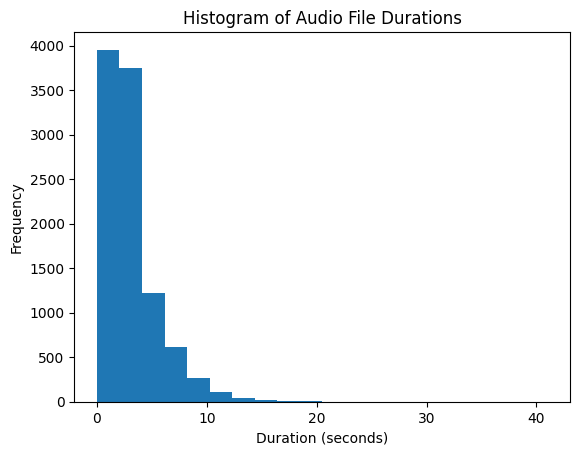

In [15]:
# plot duration of the audio files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_df['StartTime'] = pd.to_datetime(train_df['StartTime'], format='%H:%M:%S,%f')
train_df['EndTime'] = pd.to_datetime(train_df['EndTime'], format='%H:%M:%S,%f')

train_df['Duration'] = (train_df['EndTime'] - train_df['StartTime']).dt.total_seconds()

plt.hist(train_df['Duration'], bins=20)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Audio File Durations')
plt.show()

In [16]:
train_df['Duration'].describe()

count    9989.000000
mean        3.138618
std         2.425505
min         0.006000
25%         1.552000
50%         2.460000
75%         3.919000
max        41.040000
Name: Duration, dtype: float64

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from processing.preprocessing import prepare_graph_data, prepare_dataloaders
from models.MultiHeadAttention import MultiheadAttention
from models.CrossModalNet import CrossmodalNet
from models.Transformers import TransformerEncoder
from models.CombineModel import CombinedModel
from models.GraphModel import GraphModel, GraphModel_CFusion
from trainning.trainning import train_model as train
from trainning.trainning import evaluate_model as evaluate
import torch
import torch.nn as nn


from data.loaddata import load_data
import torch


data = load_data(data_type='loaders_datasets.pt')
args = {
    'modalities': ['audio', 'text', 'video'],
    'edge_type': ['temp', 'multi'],
    'wp': 2,
    'wf': 2,
    'crossmodal_nheads':2,
    'num_crossmodal':2,
    'self_att_nheads': 2,
    'num_self_att':2,
    
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'gfpush': False,
    'drop_nodes': False,
    'num_classes': 7

}

# data = load_data(data_type='loaders_datasets_reduced_label_dim_4.pt')
train_features, train_labels, train_lengths = prepare_graph_data(data['train'], args)
dev_features, dev_labels, dev_lengths = prepare_graph_data(data['val'], args)
test_features, test_labels, test_lengths = prepare_graph_data(data['test'], args)

train_loader = prepare_dataloaders(train_features, train_labels, train_lengths, batch_size=32, equilibrate=False)
val_loader = prepare_dataloaders(dev_features, dev_labels, dev_lengths, batch_size=32)
test_loader = prepare_dataloaders(test_features, test_labels, test_lengths, batch_size=32)

graphCFusionModel = GraphModel_CFusion(768, 128, 64, args['device'], args).to(args['device'])
optimizer = torch.optim.Adam(graphCFusionModel.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()


c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] Prepared features shape: torch.Size([29964, 768])
[DEBUG] Prepared labels shape: torch.Size([29964])
[DEBUG] Prepared lengths: [9988, 9988, 9988]
[DEBUG] Prepared features shape: torch.Size([3324, 768])
[DEBUG] Prepared labels shape: torch.Size([3324])
[DEBUG] Prepared lengths: [1108, 1108, 1108]
[DEBUG] Prepared features shape: torch.Size([7830, 768])
[DEBUG] Prepared labels shape: torch.Size([7830])
[DEBUG] Prepared lengths: [2610, 2610, 2610]


In [2]:
graph_cfusion_model = train(graphCFusionModel, train_loader, val_loader, optimizer, criterion, args, epochs=30, save_model='graph_cfusion_best_model.pth', log_file='graph_model_train_log.txt')


Epoch 1 Training:   0%|          | 0/937 [00:34<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 1 train loss 1.5527, val loss 1.5665, val acc 44.68%, val f1 13.08%, val precision 18.02%, val recall 16.88%


Epoch 2 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 2 train loss 1.4891, val loss 1.5664, val acc 45.01%, val f1 14.01%, val precision 22.68%, val recall 17.27%


Epoch 3 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 3 train loss 1.4676, val loss 1.5343, val acc 46.69%, val f1 17.55%, val precision 26.81%, val recall 19.42%


Epoch 4 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 4 train loss 1.4470, val loss 1.5450, val acc 46.60%, val f1 16.92%, val precision 27.06%, val recall 19.02%


Epoch 5 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 5 train loss 1.4356, val loss 1.5216, val acc 47.26%, val f1 18.77%, val precision 27.26%, val recall 20.20%


Epoch 6 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 6 train loss 1.4312, val loss 1.5186, val acc 46.72%, val f1 18.31%, val precision 26.98%, val recall 19.86%


Epoch 7 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 7 train loss 1.4288, val loss 1.5023, val acc 46.93%, val f1 18.81%, val precision 36.46%, val recall 20.10%


Epoch 8 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 8 train loss 1.4219, val loss 1.5252, val acc 46.96%, val f1 18.06%, val precision 27.47%, val recall 19.77%


Epoch 9 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 9 train loss 1.4230, val loss 1.5210, val acc 47.11%, val f1 18.00%, val precision 28.94%, val recall 19.66%


Epoch 10 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 10 train loss 1.4182, val loss 1.5139, val acc 47.23%, val f1 18.42%, val precision 27.84%, val recall 20.00%


Epoch 11 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 11 train loss 1.4163, val loss 1.5125, val acc 47.71%, val f1 19.60%, val precision 37.83%, val recall 20.77%
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.


Epoch 12 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 12 train loss 1.4076, val loss 1.5151, val acc 47.17%, val f1 18.24%, val precision 28.94%, val recall 19.82%


Epoch 13 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 13 train loss 1.4024, val loss 1.5053, val acc 47.44%, val f1 19.35%, val precision 36.02%, val recall 20.48%


Epoch 14 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 14 train loss 1.4030, val loss 1.5108, val acc 47.26%, val f1 18.75%, val precision 32.63%, val recall 20.11%


Epoch 15 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 15 train loss 1.3978, val loss 1.5083, val acc 47.47%, val f1 18.95%, val precision 33.05%, val recall 20.33%
Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.


Epoch 16 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 16 train loss 1.3898, val loss 1.5063, val acc 47.89%, val f1 20.20%, val precision 37.97%, val recall 21.03%


Epoch 17 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 17 train loss 1.3891, val loss 1.5050, val acc 47.83%, val f1 20.27%, val precision 35.83%, val recall 21.09%


Epoch 18 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 18 train loss 1.3849, val loss 1.5020, val acc 47.89%, val f1 20.42%, val precision 36.59%, val recall 21.18%


Epoch 19 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 19 train loss 1.3852, val loss 1.5021, val acc 47.56%, val f1 19.76%, val precision 33.82%, val recall 20.76%


Epoch 20 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 20 train loss 1.3844, val loss 1.4960, val acc 48.23%, val f1 20.54%, val precision 39.39%, val recall 21.25%


Epoch 21 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 21 train loss 1.3820, val loss 1.5021, val acc 47.80%, val f1 20.12%, val precision 38.21%, val recall 20.94%


Epoch 22 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 22 train loss 1.3811, val loss 1.4939, val acc 47.89%, val f1 20.19%, val precision 35.89%, val recall 21.00%


Epoch 23 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 23 train loss 1.3788, val loss 1.5018, val acc 48.16%, val f1 20.98%, val precision 36.04%, val recall 21.47%


Epoch 24 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 24 train loss 1.3780, val loss 1.4974, val acc 47.50%, val f1 20.36%, val precision 33.89%, val recall 21.04%


Epoch 25 Training:   0%|          | 0/937 [00:30<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 25 train loss 1.3750, val loss 1.5004, val acc 47.86%, val f1 20.54%, val precision 35.88%, val recall 21.16%


Epoch 26 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 26 train loss 1.3740, val loss 1.4942, val acc 47.92%, val f1 20.86%, val precision 34.52%, val recall 21.38%
Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


Epoch 27 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 27 train loss 1.3691, val loss 1.4921, val acc 47.92%, val f1 20.58%, val precision 35.00%, val recall 21.21%


Epoch 28 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 28 train loss 1.3675, val loss 1.4965, val acc 47.68%, val f1 20.99%, val precision 34.86%, val recall 21.39%


Epoch 29 Training:   0%|          | 0/937 [00:31<?, ?it/s]
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[DEBUG] Epoch 29 train loss 1.3652, val loss 1.4938, val acc 48.04%, val f1 21.11%, val precision 35.44%, val recall 21.50%


Epoch 30 Training:   0%|          | 0/937 [00:31<?, ?it/s]


[DEBUG] Epoch 30 train loss 1.3650, val loss 1.4933, val acc 48.13%, val f1 21.64%, val precision 35.18%, val recall 21.87%


c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
graphCFusionModel.load_state_dict(torch.load('graph_cfusion_best_model.pth'))
evaluate(graphCFusionModel, test_loader, args, log_file='graph_model_test_log.txt')

Testing:   1%|          | 3/245 [00:00<00:09, 26.59it/s]

Testing: 100%|██████████| 245/245 [00:04<00:00, 53.37it/s]

[DEBUG] Test Accuracy: 52.58%, Test F1 Score: 21.57%
[DEBUG] Class 0 - Precision: 53.63%, Recall: 94.69%, F1-Score: 68.48%
[DEBUG] Class 1 - Precision: 50.00%, Recall: 17.66%, F1-Score: 26.10%
[DEBUG] Class 2 - Precision: 43.20%, Recall: 14.11%, F1-Score: 21.27%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
[DEBUG] Class 4 - Precision: 36.62%, Recall: 4.17%, F1-Score: 7.48%
[DEBUG] Class 5 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
[DEBUG] Class 6 - Precision: 47.95%, Recall: 19.45%, F1-Score: 27.68%
{'0': {'precision': 0.5362994137982865, 'recall': 0.9469214437367304, 'f1-score': 0.6847711352077536, 'support': 3768.0}, '1': {'precision': 0.5, 'recall': 0.17661691542288557, 'f1-score': 0.2610294117647059, 'support': 1206.0}, '2': {'precision': 0.4319526627218935, 'recall': 0.14106280193236714, 'f1-score': 0.21267297887836853, 'support': 1035.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 204.0}, '4': {'precision': 0.36619718309859156


c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5257982120051086, 0.2157267026686954)

In [ ]:
graphmodel = graphModel.load_state_dict(torch.load('graph_cfusion_best_model.pth'))
evaluate(graphModel, test_loader, args, log_file='graph_model_test_log.txt')

Testing: 100%|██████████| 245/245 [00:05<00:00, 44.49it/s]

[DEBUG] Test Accuracy: 52.85%, Test F1 Score: 21.52%
[DEBUG] Class 0 - Precision: 53.45%, Recall: 95.73%, F1-Score: 68.60%
[DEBUG] Class 1 - Precision: 51.36%, Recall: 18.74%, F1-Score: 27.46%
[DEBUG] Class 2 - Precision: 45.67%, Recall: 11.21%, F1-Score: 18.00%
[DEBUG] Class 3 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
[DEBUG] Class 4 - Precision: 43.59%, Recall: 5.45%, F1-Score: 9.69%
[DEBUG] Class 5 - Precision: 0.00%, Recall: 0.00%, F1-Score: 0.00%
[DEBUG] Class 6 - Precision: 50.00%, Recall: 18.39%, F1-Score: 26.89%
{'0': {'precision': 0.5345287492590397, 'recall': 0.957271762208068, 'f1-score': 0.6860022822365919, 'support': 3768.0}, '1': {'precision': 0.5136363636363637, 'recall': 0.18739635157545606, 'f1-score': 0.27460510328068044, 'support': 1206.0}, '2': {'precision': 0.4566929133858268, 'recall': 0.11207729468599034, 'f1-score': 0.1799844840961986, 'support': 1035.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 204.0}, '4': {'precision': 0.435


c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\mer-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5284802043422733, 0.21518882856535024)